In [2]:
import pandas as pd
import numpy as np
import csv
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib as mpl
import time

In [3]:
import networkx as nx

In [4]:
warnings.filterwarnings('ignore')

# Content:
## Define functions for analysis
## Import and join dataframes
## Top selling Products
## Purchases over time
## Correlation
## Complexity of Apriori method
## Aprori Analysis
### Age 20-30
### Age 30-40
### Age above 40

## Define functions for analysis

All the calculations is defined as a function. 

In [5]:
def topselling(top):
    topprod=newdf.product_type_name.value_counts()
    dftop = topprod.head(top)
    return dftop.plot.bar(dftop,title='Top selling products')

#fig = go.Figure(data=[go.Histogram(y=y)])
#fig.show()

In [6]:
def age_select(age):
    if (age>=20 and age<30): return 'age20_30'
    elif (age>=30 and age<40): return 'age30_40'
    else : return 'other'

In [7]:
def age_top_selling(top):
    newdf['agecat']=newdf['age'].map(age_select)
    subsetflag=newdf.agecat=='other'
    dfage20_40=newdf[-subsetflag]
    onlydf=dfage20_40[['product_type_name','agecat']]
    only=onlydf.groupby('agecat')['product_type_name'].value_counts().reset_index(name='Count')
    topprod=only.product_type_name.head(top)
    plt.tick_params(axis='both', which='major', labelsize=8)
    return sns.barplot(data=only[only.product_type_name.isin(topprod)],x='Count',y='product_type_name', orient='h',hue='agecat')

In [8]:
def product_time(prod='Sweater'):
    mask=newdf.product_type_name==prod
    prod_time=newdf[mask]
    df1 = prod_time.groupby(prod_time['t_dat']).size().reset_index(name='Count')
    fig, ax = plt.subplots(figsize = (12,6))    
    ax.set_xticklabels(labels=df1.t_dat, rotation=45, ha='right')
    fig=sns.scatterplot(data=df1, x="t_dat", y="Count").set_title('Number of Purchases of Product over time span')
    x_dates = df1['t_dat'].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    #return sns.scatterplot(data=df1, x="t_dat", y="Count").set_title('Number of Purchases of Product over time span')
    return fig

In [9]:
def prod_corr(topXprods=10):
    topprod=newdf.product_type_name.value_counts()
    list_topX=topprod.head(topXprods)
    t=newdf[newdf.product_type_name.isin(list_topX.index)]
    t_new=t[['t_dat','product_type_name']]
    y=t_new.groupby(['t_dat','product_type_name']).size().reset_index(name='Count')
    y_new=y.pivot_table(columns=['product_type_name'],index='t_dat', values='Count')
    #fig = px.imshow(y_new.corr(),title='Correlation Between Products')
    ax = plt.axes()
    ax.set_title('Correlation Between Products')
    return sns.heatmap(y_new.corr())

In [10]:
def aprio(df,minsup=0.001):
    apo=apriori(df, min_support=minsup, use_colnames=True)
    apo['length'] = apo['itemsets'].apply(lambda x: len(x))
    apo=apo.sort_values(by=['support'],ascending=False)
    return apo

In [11]:
def freqitm(df,minsup):
    frequent_itemsets = fpgrowth(df, min_support=minsup,use_colnames=True)
    frequent_itemsets= frequent_itemsets.sort_values(by=['support'],ascending=False)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return frequent_itemsets

In [12]:
def newcol(df):
    temp=df.copy()
    temp['new_column'] = temp['itemsets'].apply(set)
    temp.new_column=temp.new_column.astype("string")
    temp=temp[temp.length==1]
    temp['prod_name'] = temp['new_column'].str.split('_').str[0]
    #freq2items['color'] = freq2items['new_column'].str.split('_').str[1]
    temp['pattern'] = temp['new_column'].str.split('_').str[1]
    temp['prod_name']=temp['prod_name'].str.replace('{','')
    temp['pattern']=temp['pattern'].str.replace('}','')
    temp['prod_name']=temp['prod_name'].str.replace('\'','')
    temp['pattern']=temp['pattern'].str.replace('\'','')
    return temp

In [13]:
def apo_rules(frequent_itemsets):
    apriori_rules=association_rules(frequent_itemsets, metric="confidence", min_threshold=0.001)
    #apriori_rules=apriori_rules.sort_values('confidence', ascending = False, inplace = True)
    return apriori_rules

In [14]:
#Function to sample frac% of customers

def sample_cust(data, frac):
    b=data.customer_id.sample(frac=frac)
    return data.loc[b.index]

## Import data and join dataframes

In [15]:
df_cust=pd.read_csv('./data/customers.csv')

In [16]:
df_cust.head()

customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [17]:
df_articles=pd.read_csv('./data/articles.csv')

In [18]:
df_articles.head(3)

article_id  product_code      prod_name  product_type_no product_type_name  \
0   108775015        108775      Strap top              253          Vest top   
1   108775044        108775      Strap top              253          Vest top   
2   108775051        108775  Strap top (1)              253          Vest top   

   product_group_name  graphical_appearance_no graphical_appearance_name  \
0  Garment Upper body                  1010016                     Solid   
1  Garment Upper body                  1010016                     Solid   
2  Garment Upper body                  1010017                    Stripe   

   colour_group_code colour_group_name  ...  department_name index_code  \
0                  9             Black  ...     Jersey Basic          A   
1                 10             White  ...     Jersey Basic          A   
2                 11         Off White  ...     Jersey Basic          A   

   index_name index_group_no  index_group_name section_no  \
0  Ladieswear              1        Ladieswear         16   
1  Ladieswear              1        Ladieswear         16   
2  Ladieswear              1        Ladieswear         16   

             section_name garment_group_no  garment_group_name  \
0  Womens Everyday Basics             1002        Jersey Basic   
1  Womens Everyday Basics             1002        Jersey Basic   
2  Womens Everyday Basics             1002        Jersey Basic   

                               detail_desc  
0  Jersey top with narrow shoulder straps.  
1  Jersey top with narrow shoulder straps.  
2  Jersey top with narrow shoulder straps.  

[3 rows x 25 columns]

In [19]:
df_articles.prod_name.unique().shape

(45875,)

In [20]:
df_articles.index_group_name.unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [21]:
df_articles.product_type_name.unique().shape

(131,)

In [22]:
df_trans=pd.read_csv('./data/transactions_train.csv')

In [23]:
df_trans.shape

(31788324, 5)

In [24]:
df_trans.head()

t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

In [25]:
df_trans['t_dat'] = pd.to_datetime(df_trans['t_dat'])

In [26]:
df_trans.t_dat.min()

Timestamp('2018-09-20 00:00:00')

In [27]:
df_trans.t_dat.max()

Timestamp('2020-09-22 00:00:00')

Time span in days

In [28]:
spandays=(df_trans.t_dat.max()-df_trans.t_dat.min())

In [29]:
print('Span in Years',spandays / np.timedelta64(1, 'Y'))

Span in Years 2.006885836122576


On transaction data frame join the articles data frame

In [30]:
newdf=df_trans.merge(df_articles,on='article_id', how='left')

In [31]:
newdf.head(2)

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   

      price  sales_channel_id  product_code                 prod_name  \
0  0.050831                 2        663713  Atlanta Push Body Harlow   
1  0.030492                 2        541518   Rae Push (Melbourne) 2p   

   product_type_no product_type_name product_group_name  ...  \
0              283    Underwear body          Underwear  ...   
1              306               Bra          Underwear  ...   

       department_name index_code        index_name index_group_no  \
0  Expressive Lingerie          B  Lingeries/Tights              1   
1      Casual Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no     section_name garment_group_no  \
0        Ladieswear         61  Womens Lingerie             1017   
1        Ladieswear         61  Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0   Under-, Nightwear  Lace push-up body with underwired, moulded, pa...  
1   Under-, Nightwear  Lace push-up bras with underwired, moulded, pa...  

[2 rows x 29 columns]

And finaly join the customer data frame to dataframe

In [32]:
newdf=newdf.merge(df_cust,on='customer_id', how='left')

In [33]:
#product categories 
newdf.product_group_name.unique()

array(['Underwear', 'Garment Upper body', 'Garment Lower body',
       'Accessories', 'Socks & Tights', 'Shoes', 'Garment Full body',
       'Nightwear', 'Swimwear', 'Underwear/nightwear', 'Cosmetic',
       'Unknown', 'Items', 'Bags', 'Interior textile', 'Furniture',
       'Garment and Shoe care', 'Stationery', 'Fun'], dtype=object)

The data frame is final 'joined' dataframe.


The variable 'index_group_name' can be a proxy for sex.

In [34]:
newdf.index_group_name.value_counts()

Ladieswear       20415260
Divided           7138254
Menswear          1771053
Sport             1246408
Baby/Children     1217349
Name: index_group_name, dtype: int64

Add agegroup variable to the dataframe derived from the age. 

In [35]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
#labels = ['Teen','Young Adult', 'Adult']
newdf['AgeGroup'] = pd.cut(newdf['age'], bins=bins, right=True)


In [36]:

ag = newdf.groupby('index_group_name').AgeGroup.value_counts().sort_index()

In [37]:
ag.unstack()

AgeGroup          (0, 10]  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  \
index_group_name                                                              
Baby/Children           0     20698    213336    378524    432052    124946   
Divided                 0    499284   3302778   1089523   1119271    907514   
Ladieswear              0    839648   8716621   3657362   3132015   3122457   
Menswear                0     70808    666335    264962    334316    353188   
Sport                   0     41715    562056    238828    197483    171928   

AgeGroup          (60, 70]  (70, 80]  (80, 90]  (90, 100]  
index_group_name                                           
Baby/Children        31381      5490       397          9  
Divided             163792     24494      2043        254  
Ladieswear          727597    124593      7909        847  
Menswear             64148      8304       518         63  
Sport                25804      2552       174         49

Final dimensions of the data file 

In [38]:
newdf.shape

(31788324, 36)

In [39]:
#newdf.dtypes

In [40]:
len(newdf.prod_name.unique())

45508

In [41]:
newdf.head(3)

t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   

      price  sales_channel_id  product_code                 prod_name  \
0  0.050831                 2        663713  Atlanta Push Body Harlow   
1  0.030492                 2        541518   Rae Push (Melbourne) 2p   
2  0.015237                 2        505221               Inca Jumper   

   product_type_no product_type_name  product_group_name  ...  \
0              283    Underwear body           Underwear  ...   
1              306               Bra           Underwear  ...   
2              252           Sweater  Garment Upper body  ...   

   garment_group_no garment_group_name  \
0              1017  Under-, Nightwear   
1              1017  Under-, Nightwear   
2              1003           Knitwear   

                                         detail_desc   FN  Active  \
0  Lace push-up body with underwired, moulded, pa...  NaN     NaN   
1  Lace push-up bras with underwired, moulded, pa...  NaN     NaN   
2  Jumper in rib-knit cotton with hard-worn detai...  1.0     1.0   

  club_member_status  fashion_news_frequency   age  \
0             ACTIVE                    NONE  24.0   
1             ACTIVE                    NONE  24.0   
2             ACTIVE               Regularly  32.0   

                                         postal_code  AgeGroup  
0  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  (20, 30]  
1  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  (20, 30]  
2  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  (30, 40]  

[3 rows x 36 columns]

Hannahs Filter

In [42]:
newdf = newdf[newdf.colour_group_name != 'Black' ]
newdf = newdf[newdf.colour_group_name != 'White' ]
newdf = newdf[newdf.colour_group_name != 'Dark Blue' ]

newdf = newdf[newdf.product_type_name != 'Trousers' ]



In [43]:
newdf = newdf[newdf.groupby('product_type_name').product_type_name.transform(len) > 1000]


In [44]:
newdf = newdf.dropna()

newdf.head(4)

t_dat                                        customer_id  article_id  \
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   
5 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687001   

      price  sales_channel_id  product_code             prod_name  \
2  0.015237                 2        505221           Inca Jumper   
3  0.016932                 2        685687  W YODA KNIT OL OFFER   
4  0.016932                 2        685687  W YODA KNIT OL OFFER   
5  0.016932                 2        685687  W YODA KNIT OL OFFER   

   product_type_no product_type_name  product_group_name  ...  \
2              252           Sweater  Garment Upper body  ...   
3              252           Sweater  Garment Upper body  ...   
4              252           Sweater  Garment Upper body  ...   
5              252           Sweater  Garment Upper body  ...   

   garment_group_no garment_group_name  \
2              1003           Knitwear   
3              1023     Special Offers   
4              1023     Special Offers   
5              1023     Special Offers   

                                         detail_desc   FN  Active  \
2  Jumper in rib-knit cotton with hard-worn detai...  1.0     1.0   
3  V-neck knitted jumper with long sleeves and ri...  1.0     1.0   
4  V-neck knitted jumper with long sleeves and ri...  1.0     1.0   
5  V-neck knitted jumper with long sleeves and ri...  1.0     1.0   

  club_member_status  fashion_news_frequency   age  \
2             ACTIVE               Regularly  32.0   
3             ACTIVE               Regularly  32.0   
4             ACTIVE               Regularly  32.0   
5             ACTIVE               Regularly  32.0   

                                         postal_code  AgeGroup  
2  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  (30, 40]  
3  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  (30, 40]  
4  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  (30, 40]  
5  8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...  (30, 40]  

[4 rows x 36 columns]

# Top Selling products

The most top ranking purchased products 

<AxesSubplot:title={'center':'Top selling products'}>

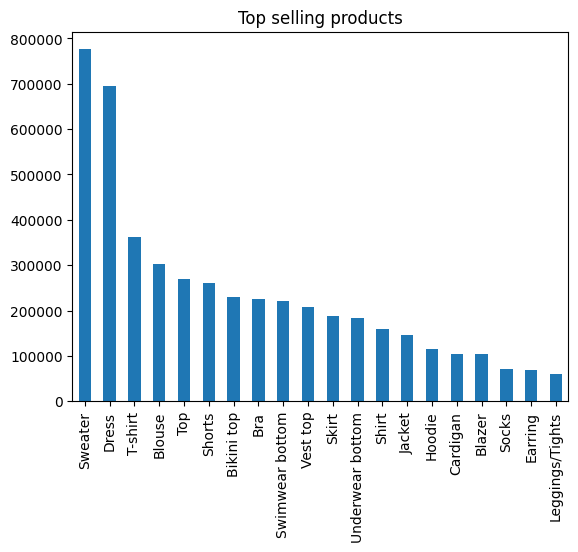

In [45]:
topselling(20)

<AxesSubplot:xlabel='Count', ylabel='product_type_name'>

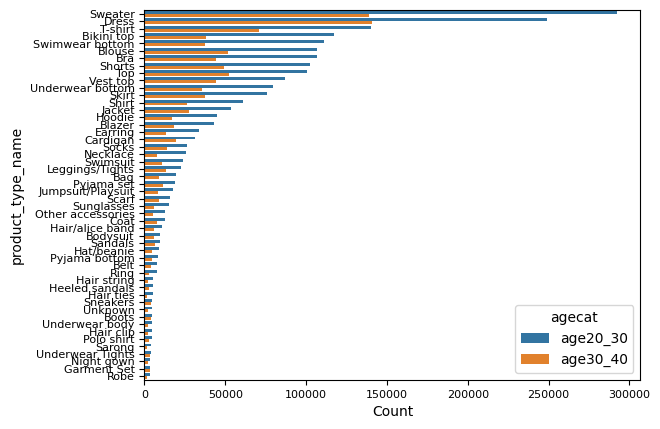

In [46]:
age_top_selling(50)

# Correlation

<AxesSubplot:title={'center':'Correlation Between Products'}, xlabel='product_type_name', ylabel='product_type_name'>

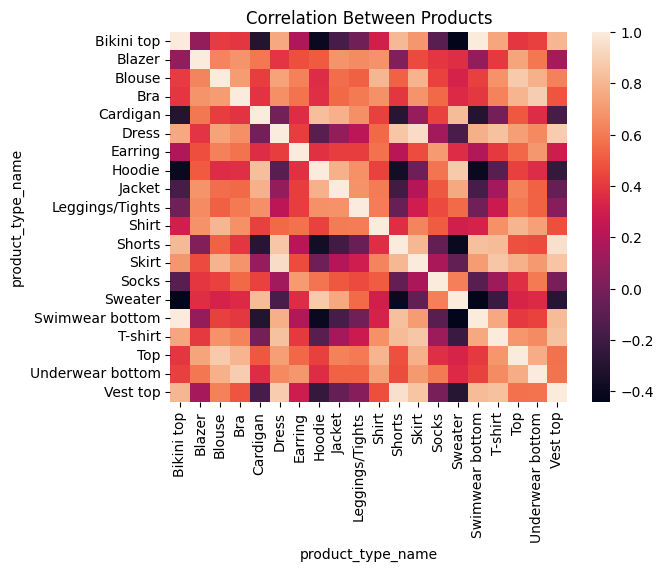

In [47]:
prod_corr(20)

# Purchases over Time

Text(0.5, 1.0, 'Number of Purchases of Product over time span')

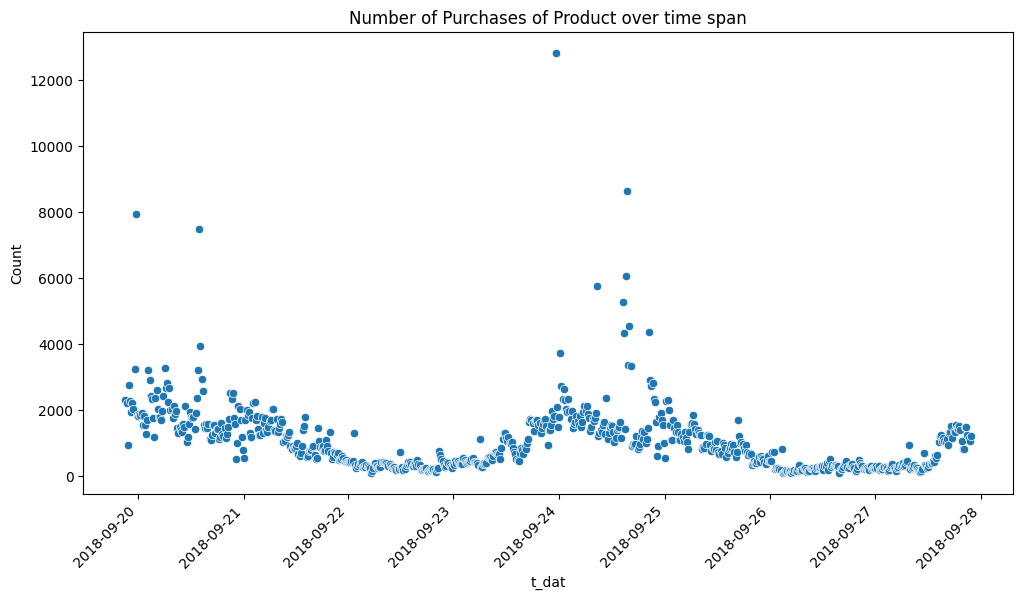

In [48]:
# T-shirt and Swimsuit Jacket Shorts
product_time('Sweater')

# Complexity of Apriori Method

On page 215 and 216 in the textbook it is shown how we can calculate the memory requirement.
The number of rows in purchases_list is :

$$len(purchases\_list)=9.080.179 \hspace{0.5cm} baskets $$

We can calculate the number of unique items in our dataset:

$$ len(testnew.prod\_name.unique())=5.424.262 $$

Note testnew is my input to purchases_list so it must be same number items in purchases_list.

The number of pairs as:

$$\binom{5.424.262}{ 2}$$

This is approximately 

$$\frac{5.424.262^2}{2}=  1,47E+13 \hspace{0.5cm } store\hspace{0.1cm} space. $$

If integers take 4 bytes then it requires $2 \cdot items^2$ bytes.

This gives $2\cdot 5.424.262^2=5,88E+13$ bytes and equivalent to 58.845 Gigabytes. This figure should then be multiplied by number of baskets. 

The big O complexity of the Apriori method is $O(2^D)$ - which is exponential. 

# Aprori Analysis

Only use variables t_dat, customer_id, prod_name and age. For use in aprori analysis below.

In [49]:
len(newdf.colour_group_name.unique())

47

In [50]:
len(newdf.graphical_appearance_name.unique())

30

In [367]:
#cols = ['product_type_name', 'colour_group_name', 'graphical_appearance_name']
#cols = ['product_type_name', 'graphical_appearance_name']
cols = ['product_type_name', 'colour_group_name']
newdf['combined'] = newdf[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [368]:
#select_newdf=newdf[['t_dat','customer_id','prod_name','age']]
select_newdf=newdf[['t_dat','customer_id','combined','age']]

In [369]:
select_newdf.head(3)

t_dat                                        customer_id  \
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
3 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   
4 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   

             combined   age  
2        Sweater_Pink  32.0  
3        Sweater_Pink  32.0  
4  Sweater_Dark Green  32.0

In [370]:
test = select_newdf.groupby(['customer_id', 't_dat','age'])['combined'].apply(lambda x: ','.join(x.astype(str))).reset_index() 

In [371]:
testnew=pd.DataFrame(test)

In [372]:
testnew.head()

customer_id      t_dat   age  \
0  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f... 2019-03-07  52.0   
1  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f... 2020-06-03  52.0   
2  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f... 2020-08-12  52.0   
3  00007d2de826758b65a93dd24ce629ed66842531df6699... 2018-09-20  32.0   
4  00007d2de826758b65a93dd24ce629ed66842531df6699... 2018-09-23  32.0   

                                            combined  
0   Bikini top_Light Blue,Swimwear bottom_Light Blue  
1                        Underwear body_Light Orange  
2                                      T-shirt_Green  
3  Sweater_Pink,Sweater_Pink,Sweater_Dark Green,S...  
4  Underwear bottom_Light Pink,Underwear bottom_D...

In [373]:
len(testnew)

2543001

In [374]:
age20_30=testnew[(testnew.age>=20) & (testnew.age<30)]
age30_40=testnew[(testnew.age>=30) & (testnew.age<40)]
age40_50=testnew[(testnew.age>=40) & (testnew.age<50)]
age40_above=testnew[(testnew.age>=40)]

Number of customers betweeen age 20-30:

In [375]:
len(age20_30)

1002741

In [376]:
# Here I sample the data

o20_30=sample_cust(age20_30,0.5)
o30_40=sample_cust(age30_40,0.5)
o40_50=sample_cust(age40_50,0.5)
o_above40=sample_cust(age40_above,0.5)

This is the number of unique customers: 

In [377]:
print(len(o20_30))
print(len(o30_40))
print(len(o40_50))
print(len(o_above40))

501370
214029
194972
519604


This is the number of unique items in the frac% customer sample:

In [378]:
print(len(o30_40.combined.unique()))
print(len(o20_30.combined.unique()))
print(len(o_above40.combined.unique()))

99391
184787
179451


In [379]:
# Only the basket
prods20_30=o20_30['combined']
prods30_40=o30_40['combined']
prods40_50=o40_50['combined']
prods_above40=o_above40['combined']


In [380]:
art20_30=prods20_30.values.tolist()
art30_40=prods30_40.values.tolist()
art40_50=prods40_50.values.tolist()
art40above=prods_above40.values.tolist()

In [381]:
print(art20_30[0])
print(art30_40[0])
print(art40_50[0])
print(art40above[0])

Jacket_Dark Grey
Blouse_Off White,Dress_Yellow,Dress_Yellow,Dress_Light Beige,Blouse_Yellowish Brown,Dress_Off White,Dress_Off White
Underwear bottom_Dark Grey,Underwear bottom_Dark Grey,Bra_Red
Blazer_Light Grey,Sweater_Light Pink


The same function as Hannah

In [382]:
purchaseslist20_30 = [] 
purchaseslist30_40 = [] 
purchaseslist40_50 = []
purchaseslist40above = []

for i in art20_30:
    #print(i)
    purchaseslist20_30.append(i.split(",")) 



for i in art30_40:
    #print(i)
    purchaseslist30_40.append(i.split(",")) 

for i in art40_50:
    #print(i)
    purchaseslist40_50.append(i.split(",")) 

for i in art40above:
    #print(i)
    purchaseslist40above.append(i.split(",")) 

In [132]:
#Export the purchases_list to csv file

fields = ['BasketNew']
with open('o', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(purchaseslist30_40)

In [383]:
#Sparse=True go in fit 
te = TransactionEncoder()
te_ary = te.fit(purchaseslist20_30).transform(purchaseslist20_30)
df20_30 = pd.DataFrame(te_ary,columns=te.columns_)


te_ary = te.fit(purchaseslist30_40).transform(purchaseslist30_40)
df30_40 = pd.DataFrame(te_ary,columns=te.columns_)

te_ary = te.fit(purchaseslist40_50).transform(purchaseslist40_50)
df40_50 = pd.DataFrame(te_ary,columns=te.columns_)


te_ary = te.fit(purchaseslist40above).transform(purchaseslist40above)
df40above = pd.DataFrame(te_ary,columns=te.columns_)


In [384]:
df20_30.head()


Bag_Beige  Bag_Blue  Bag_Bronze/Copper  Bag_Dark Beige  Bag_Dark Green  \
0      False     False              False           False           False   
1      False     False              False           False           False   
2      False     False              False           False           False   
3      False     False              False           False           False   
4      False     False              False           False           False   

   Bag_Dark Grey  Bag_Dark Orange  Bag_Dark Pink  Bag_Dark Red  \
0          False            False          False         False   
1          False            False          False         False   
2          False            False          False         False   
3          False            False          False         False   
4          False            False          False         False   

   Bag_Dark Turquoise  ...  Wedge_Green  Wedge_Light Beige  \
0               False  ...        False              False   
1               False  ...        False              False   
2               False  ...        False              False   
3               False  ...        False              False   
4               False  ...        False              False   

   Wedge_Light Orange  Wedge_Light Pink  Wedge_Light Red  Wedge_Orange  \
0               False             False            False         False   
1               False             False            False         False   
2               False             False            False         False   
3               False             False            False         False   
4               False             False            False         False   

   Wedge_Red  Wedge_Turquoise  Wedge_Yellow  Wedge_Yellowish Brown  
0      False            False         False                  False  
1      False            False         False                  False  
2      False            False         False                  False  
3      False            False         False                  False  
4      False            False         False                  False  

[5 rows x 2113 columns]

The above dimsions have really confused me !!!! The rows does not fit....But look below.

In [385]:
df20_30.shape

(501370, 2113)

## Age group 20-30

In [386]:
# Age 20-30
# 0.0001 too much
import time
start=time.time()
apo=aprio(df20_30,0.001)
elapsedtime=(time.time()-start)
print('elapsed time',elapsedtime)

elapsed time 888.358592748642


In [387]:
apo

support                            itemsets  length
264  0.029427                      (Sweater_Grey)       1
275  0.023683                 (Sweater_Off White)       1
252  0.023508                     (Sweater_Beige)       1
106  0.022879                 (Dress_Light Beige)       1
266  0.022153               (Sweater_Light Beige)       1
..        ...                                 ...     ...
130  0.001009            (Hair/alice band_Yellow)       1
437  0.001005  (Sweater_Grey, Sweater_Dark Green)       2
62   0.001005              (Bodysuit_Dark Orange)       1
173  0.001001             (Other accessories_Red)       1
383  0.001001                (Vest top_Dark Pink)       1

[445 rows x 3 columns]

In [388]:
#age 20-30

apo[apo.length==1]

support                  itemsets  length
264  0.029427            (Sweater_Grey)       1
275  0.023683       (Sweater_Off White)       1
252  0.023508           (Sweater_Beige)       1
106  0.022879       (Dress_Light Beige)       1
266  0.022153     (Sweater_Light Beige)       1
..        ...                       ...     ...
170  0.001023   (Night gown_Light Pink)       1
130  0.001009  (Hair/alice band_Yellow)       1
62   0.001005    (Bodysuit_Dark Orange)       1
173  0.001001   (Other accessories_Red)       1
383  0.001001      (Vest top_Dark Pink)       1

[400 rows x 3 columns]

In [389]:
# age 20-30
# the same as above but faster 
start=time.time()
freq20_30=freqitm(df20_30,0.0001)
elapsedtime=(time.time()-start)
print('elapsed time',elapsedtime)

elapsed time 9.550580978393555


In [390]:
freq20_30

support                                           itemsets  length
1     0.029427                                     (Sweater_Grey)       1
34    0.023683                                (Sweater_Off White)       1
27    0.023508                                    (Sweater_Beige)       1
25    0.022879                                (Dress_Light Beige)       1
136   0.022153                              (Sweater_Light Beige)       1
...        ...                                                ...     ...
1753  0.000102  (Dress_Light Beige, Dress_Light Pink, Dress_Gr...       3
1754  0.000102  (Dress_Off White, Dress_Light Pink, Dress_Gree...       3
1773  0.000102              (T-shirt_Off White, Dress_Light Pink)       2
706   0.000102                                (Shirt_Dark Purple)       1
2916  0.000102              (Vest top_Pink, Leggings/Tights_Grey)       2

[3849 rows x 3 columns]

In [391]:
freq20_30.itemsets[15]

frozenset({'Swimwear set_Blue'})

In [392]:
freq2items20_30=newcol(freq20_30)

In [393]:
freq2items20_30.shape

(1151, 6)

In [394]:
freq2items20_30.head(2)

support             itemsets  length             new_column prod_name  \
1   0.029427       (Sweater_Grey)       1       {'Sweater_Grey'}   Sweater   
34  0.023683  (Sweater_Off White)       1  {'Sweater_Off White'}   Sweater   

      pattern  
1        Grey  
34  Off White

In [395]:
freq2items20_30.support=freq2items20_30.support*100

In [396]:
vmax=freq2items20_30.support.max()
vmin=freq2items20_30.support.min()

In [397]:
vmax

2.942736900891557

In [398]:
vmin

0.010172128368270937

In [399]:
G=nx.Graph()

In [400]:
G=nx.from_pandas_edgelist(freq2items20_30,source='prod_name',target='pattern', edge_attr='support')
G.edges(data=True)

EdgeDataView([('Sweater', 'Grey', {'support': 2.942736900891557}), ('Sweater', 'Off White', {'support': 2.3683108283303747}), ('Sweater', 'Beige', {'support': 2.350758920557672}), ('Sweater', 'Light Beige', {'support': 2.2153299958114765}), ('Sweater', 'Dark Grey', {'support': 1.4747591599018688}), ('Sweater', 'Dark Red', {'support': 1.382412190597762}), ('Sweater', 'Light Pink', {'support': 1.2122783573009954}), ('Sweater', 'Light Grey', {'support': 1.1849532281548556}), ('Sweater', 'Dark Green', {'support': 1.162614436444143}), ('Sweater', 'Red', {'support': 1.139278377246345}), ('Sweater', 'Yellow', {'support': 1.0876199214153222}), ('Sweater', 'Pink', {'support': 0.8722101442048786}), ('Sweater', 'Greenish Khaki', {'support': 0.8682210742565372}), ('Sweater', 'Dark Beige', {'support': 0.8305243632447095}), ('Sweater', 'Yellowish Brown', {'support': 0.6905080080579212}), ('Sweater', 'Light Orange', {'support': 0.5576719787781479}), ('Sweater', 'Blue', {'support': 0.4818796497596586}

In [401]:
edges,support=zip(*nx.get_edge_attributes(G,'support').items())

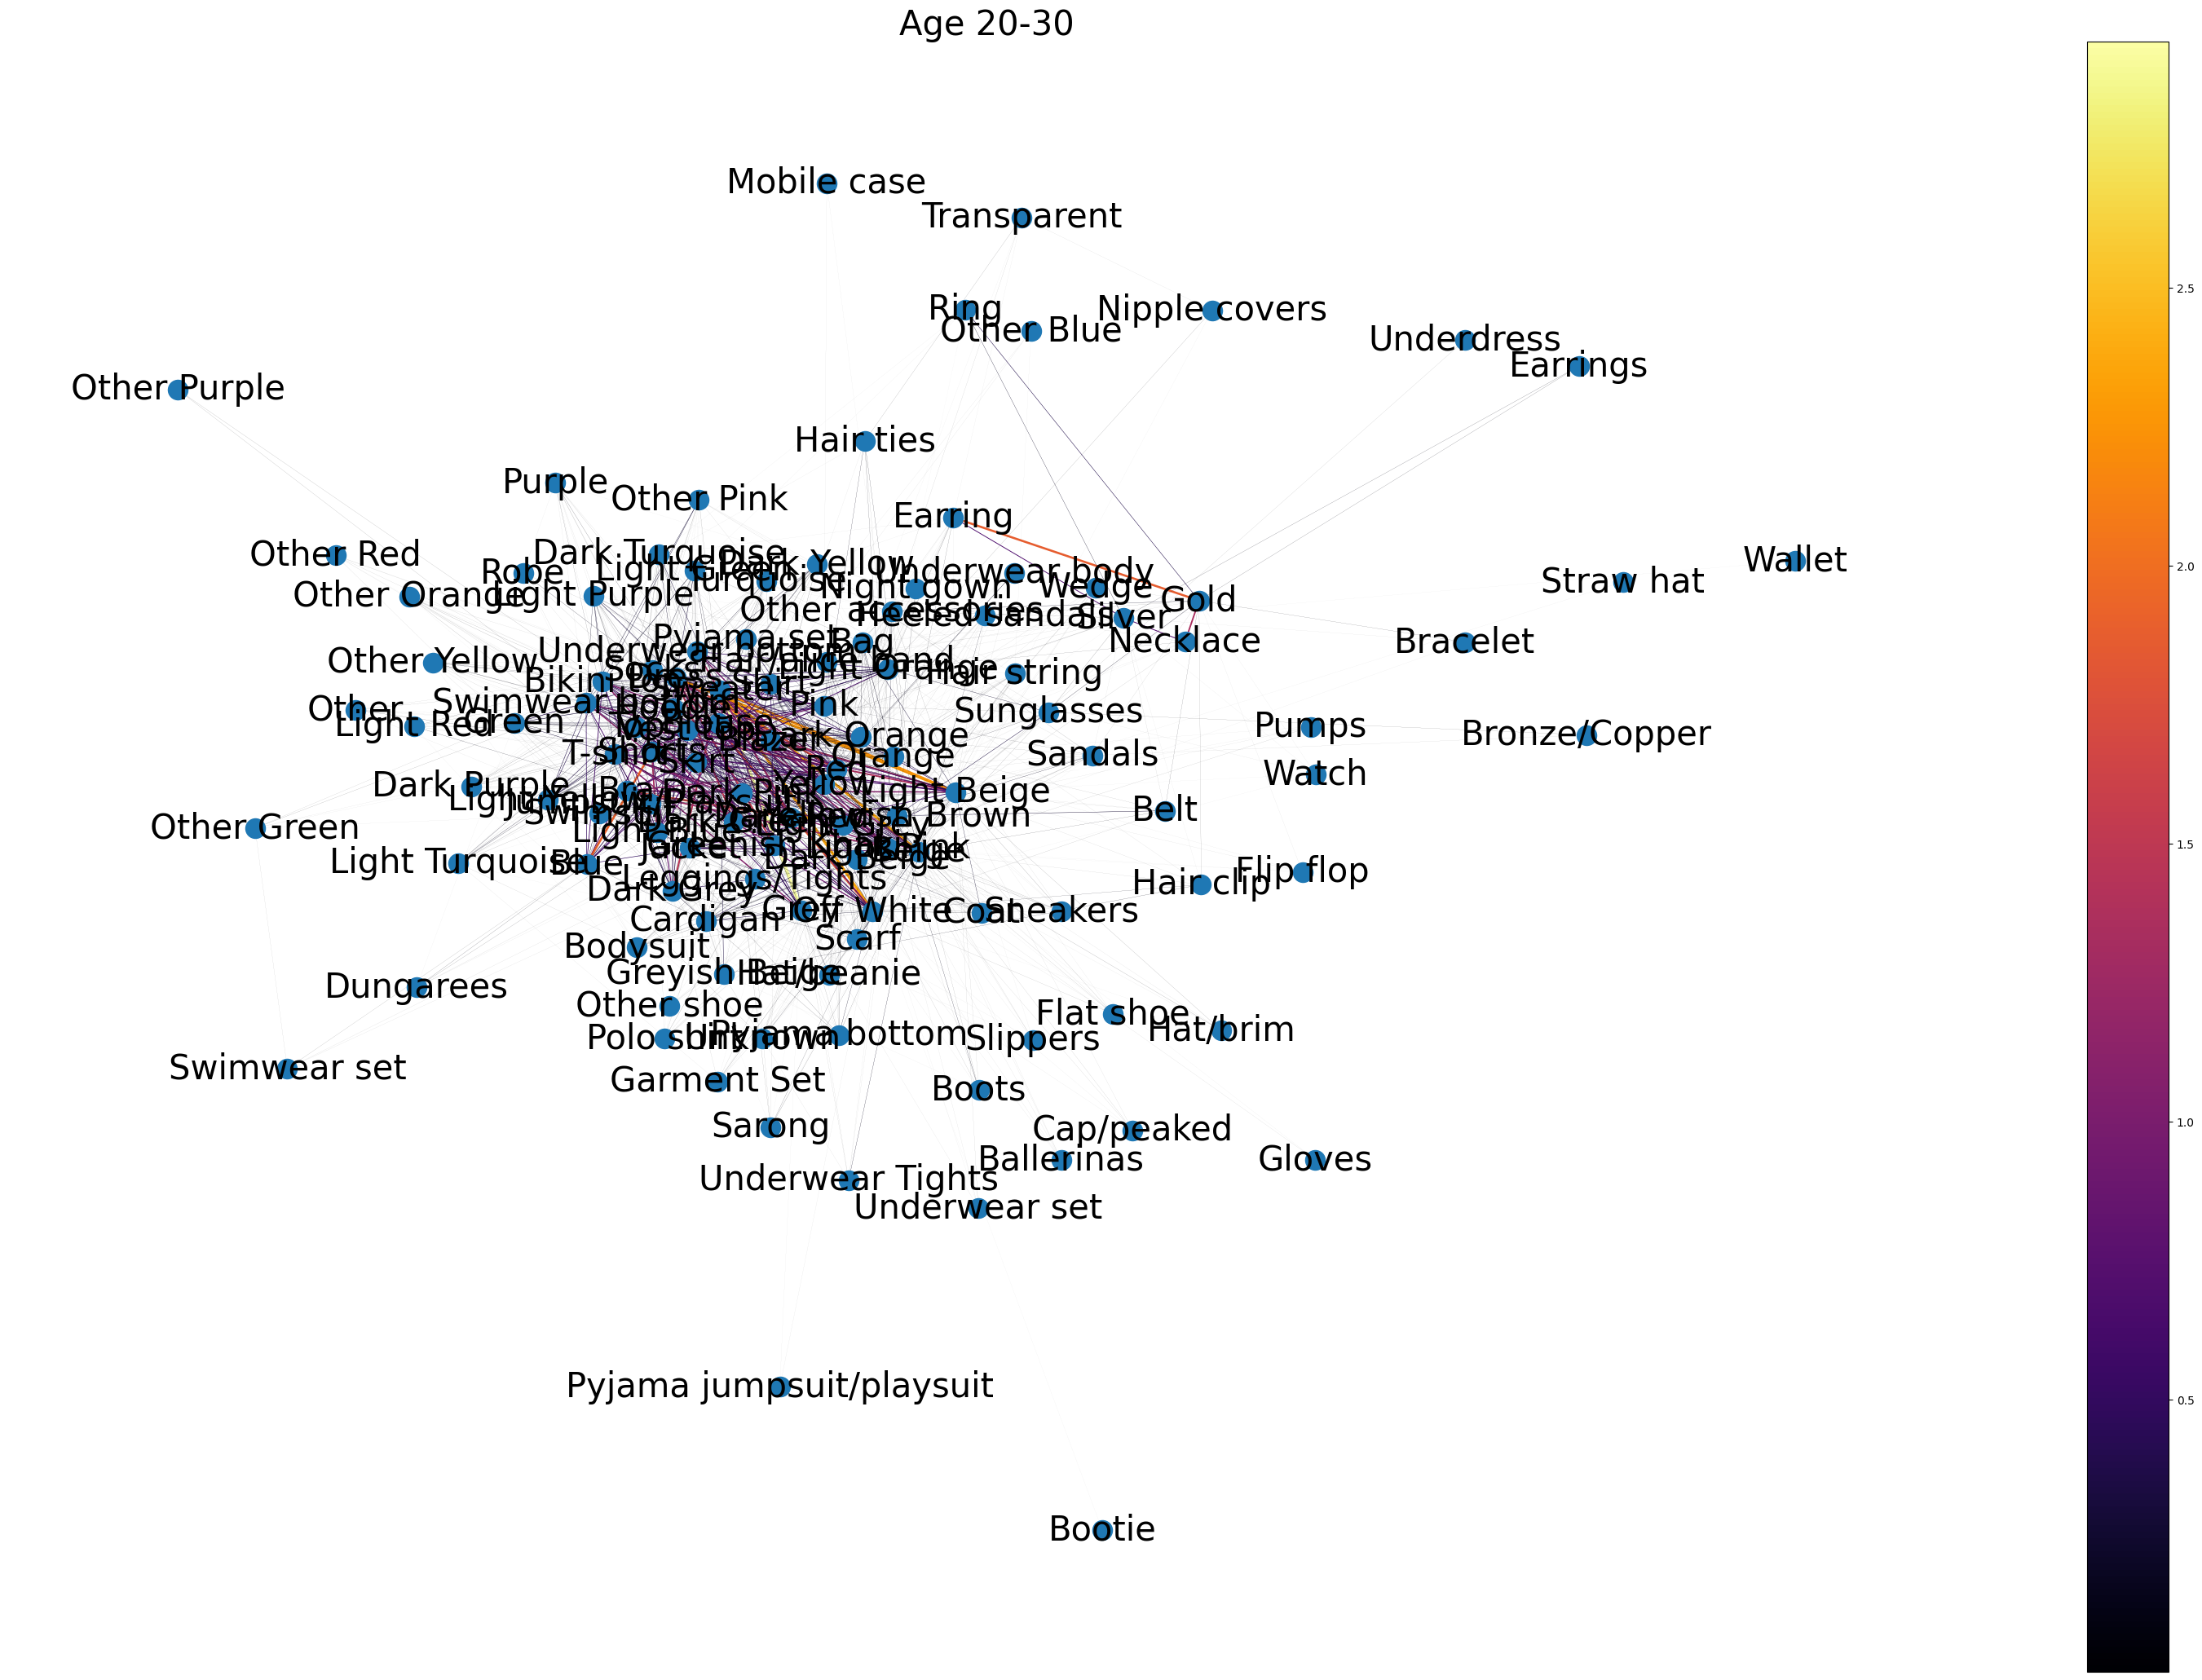

In [402]:

figure(figsize=(30,20))
cmap = plt.cm.inferno
f=nx.draw(G,width=support,with_labels=True,edge_color=support,edge_cmap=cmap,font_size=30)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
plt.colorbar(sm)
plt.title('Age 20-30',fontsize=30)
plt.show()

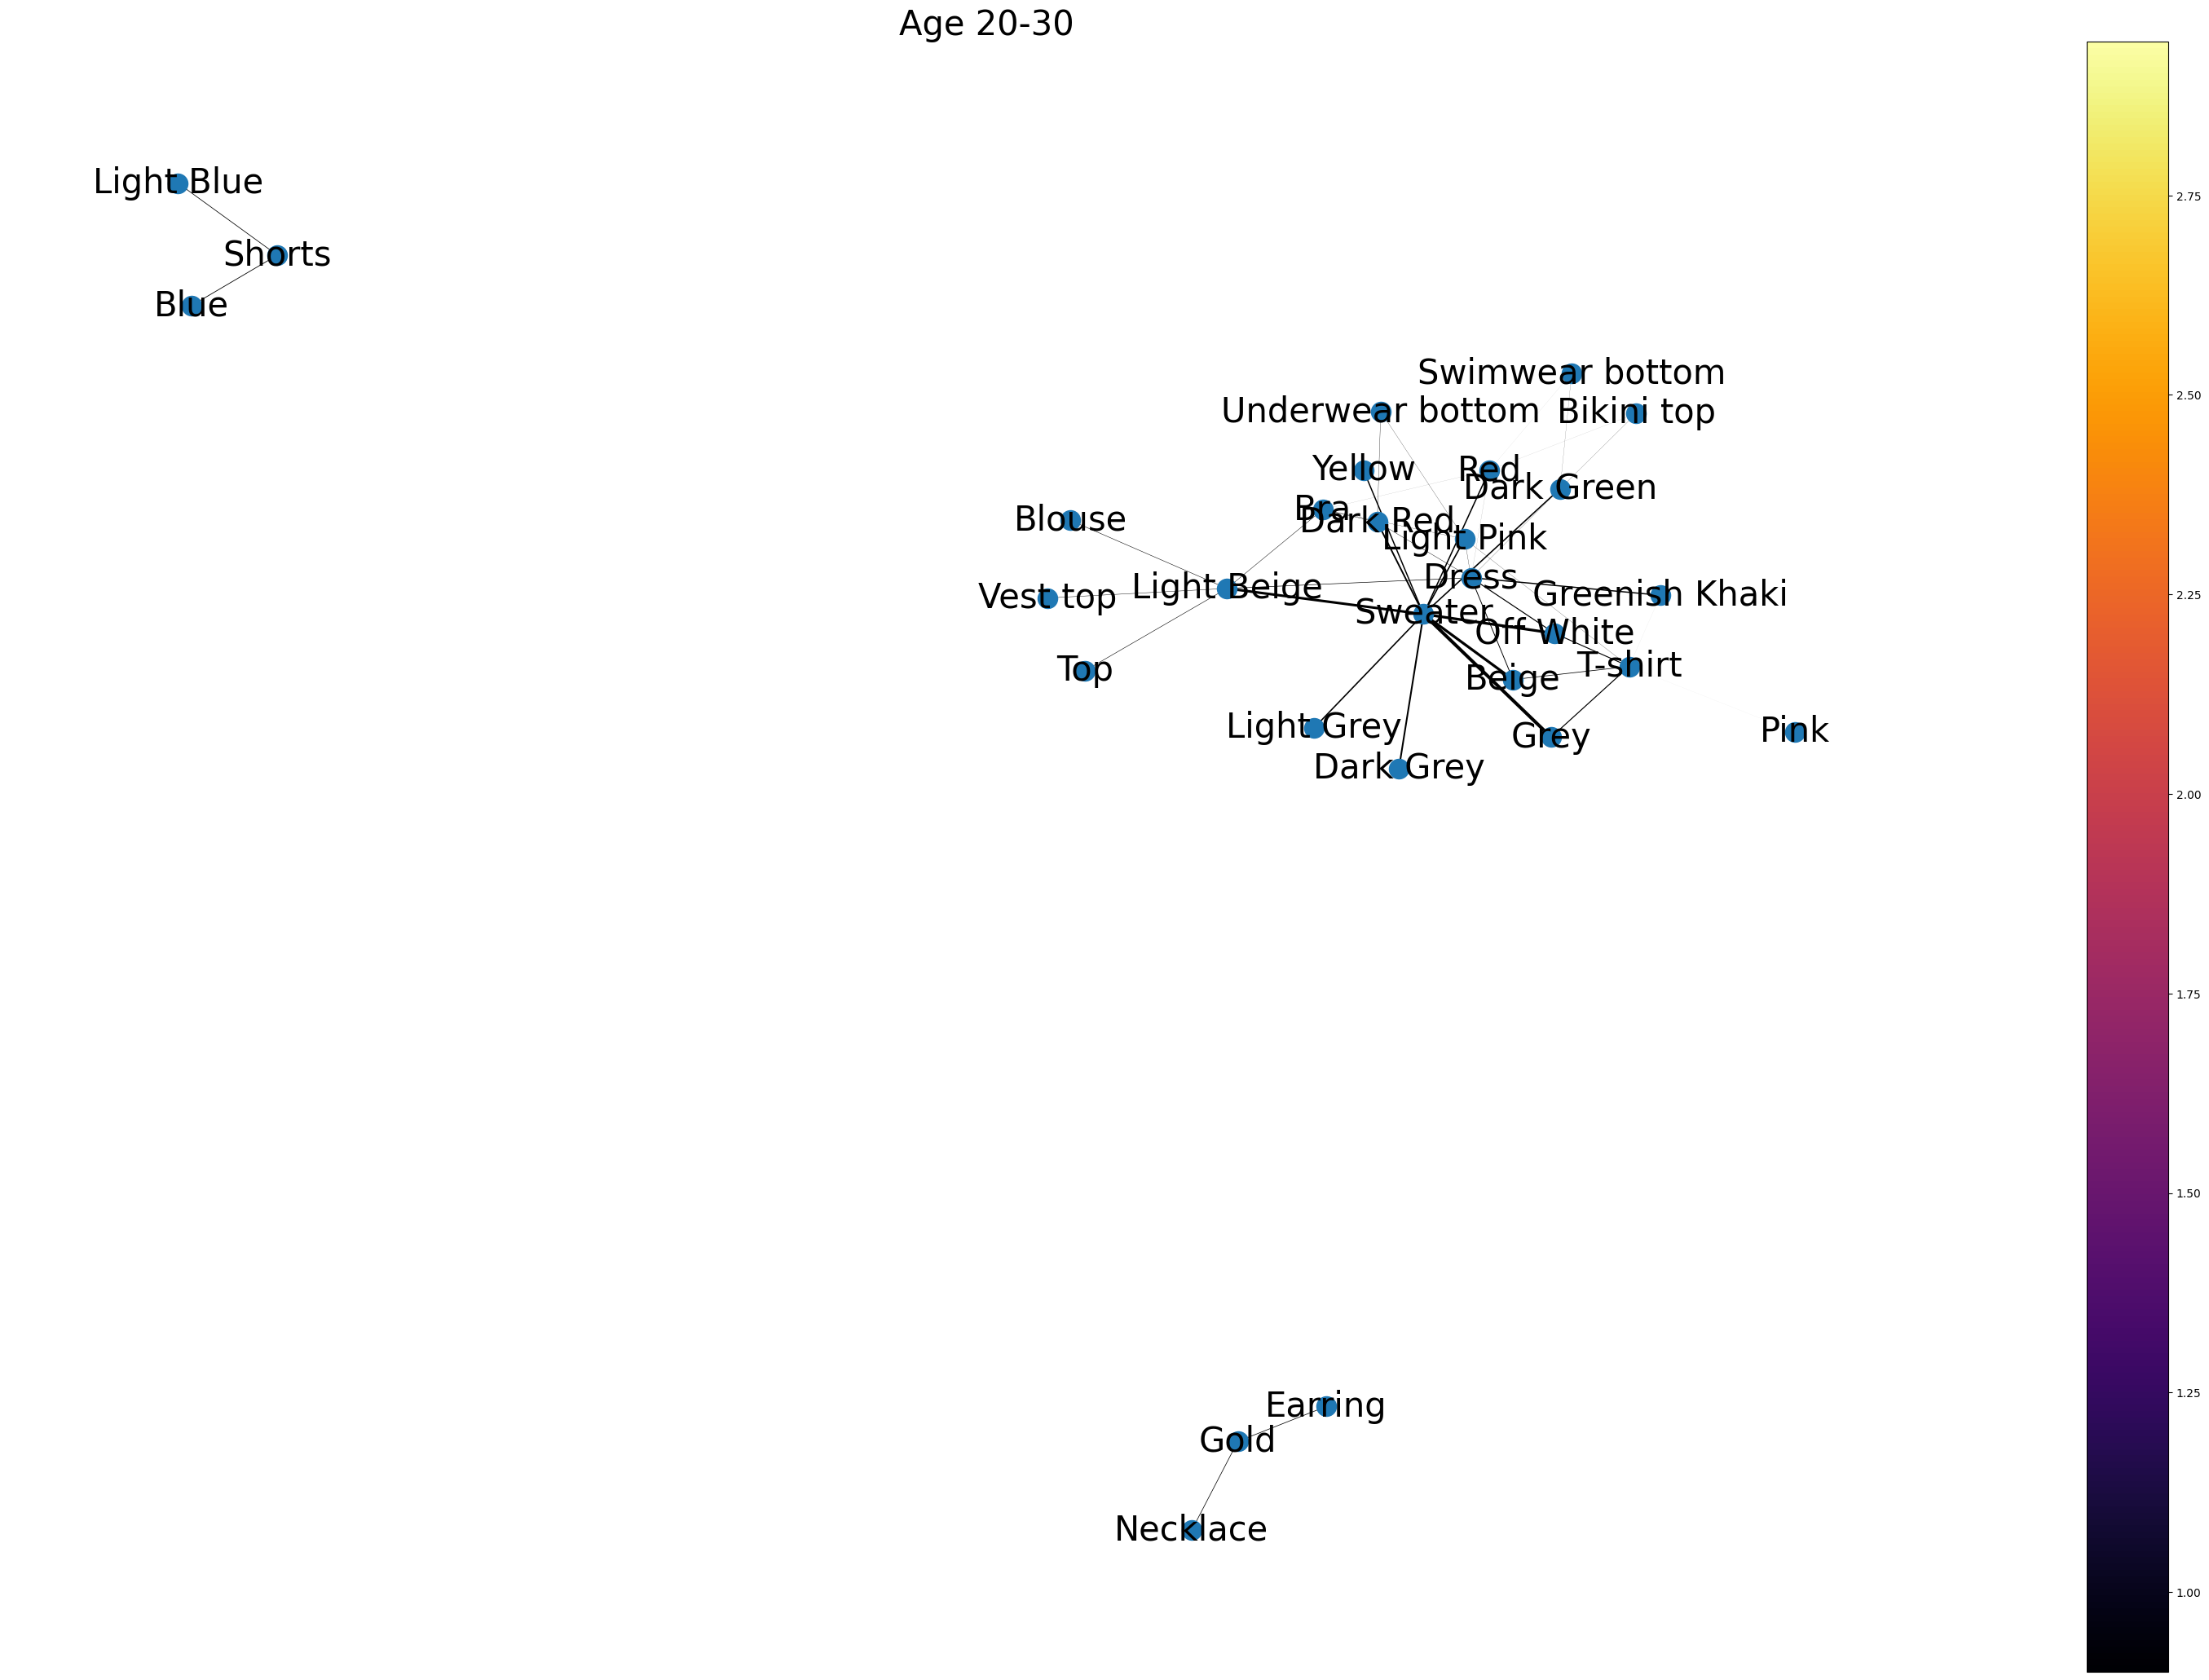

In [403]:


figure(figsize=(30,20))
cmap = plt.cm.inferno
select_edges=((u, v, e) for u,v,e in G.edges(data=True) if e['support'] >=0.9)
H = nx.Graph(select_edges)
f=nx.draw(H,with_labels=True,width=support,font_size=30)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin = .9, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Age 20-30',fontsize=30)
plt.show()







In [404]:
apo_rules(freq20_30).sort_values('confidence', ascending = False)

antecedents  \
3338  (Swimwear bottom_Yellow, Bikini top_Blue, Swim...   
3366  (Bikini top_Off White, Swimwear bottom_Blue, S...   
2760     (Swimwear bottom_Yellow, Swimwear bottom_Blue)   
3908  (Swimwear bottom_Greenish Khaki, Sarong_Greeni...   
3907  (Bikini top_Greenish Khaki, Sarong_Greenish Kh...   
...                                                 ...   
6720                                     (Sweater_Grey)   
6724                                     (Sweater_Grey)   
6933                                     (Sweater_Grey)   
7009                                     (Sweater_Grey)   
6942                                     (Sweater_Grey)   

                                 consequents  antecedent support  \
3338                     (Bikini top_Yellow)            0.000160   
3366                       (Bikini top_Blue)            0.000162   
2760                     (Bikini top_Yellow)            0.000180   
3908             (Bikini top_Greenish Khaki)            0.000150   
3907        (Swimwear bottom_Greenish Khaki)            0.000150   
...                                      ...                 ...   
6720                        (T-shirt_Yellow)            0.029427   
6724                            (Skirt_Grey)            0.029427   
6933  (Sweater_Off White, Sweater_Dark Grey)            0.029427   
7009                              (Bra_Pink)            0.029427   
6942                        (Top_Light Pink)            0.029427   

      consequent support   support  confidence        lift  leverage  \
3338            0.005627  0.000158    0.987500  175.506159  0.000157   
3366            0.006193  0.000158    0.975309  157.484861  0.000157   
2760            0.005627  0.000174    0.966667  171.803498  0.000173   
3908            0.002086  0.000144    0.960000  460.148375  0.000143   
3907            0.001701  0.000144    0.960000  564.261665  0.000143   
...                  ...       ...         ...         ...       ...   
6720            0.004264  0.000104    0.003524    0.826503 -0.000022   
6724            0.001241  0.000104    0.003524    2.840936  0.000067   
6933            0.000594  0.000102    0.003457    5.815706  0.000084   
7009            0.007908  0.000102    0.003457    0.437095 -0.000131   
6942            0.004847  0.000102    0.003457    0.713202 -0.000041   

      conviction  
3338   79.549873  
3366   40.249182  
2760   29.831203  
3908   24.947843  
3907   24.957467  
...          ...  
6720    0.999258  
6724    1.002292  
6933    1.002872  
7009    0.995533  
6942    0.998605  

[7136 rows x 9 columns]

## Age group 30-40

In [405]:
apo=aprio(df30_40,0.001)

In [406]:
apo

support                                  itemsets  length
298  0.032748                            (Sweater_Grey)       1
112  0.026809                       (Dress_Light Beige)       1
122  0.024193                         (Dress_Off White)       1
286  0.023978                           (Sweater_Beige)       1
300  0.023801                     (Sweater_Light Beige)       1
..        ...                                       ...     ...
473  0.001009                 (Dress_Yellow, Dress_Red)       2
325  0.001009                         (Swimsuit_Yellow)       1
385  0.001009                          (Top_Light Blue)       1
135  0.001005                     (Hair clip_Off White)       1
461  0.001005  (Dress_Dark Green, Dress_Greenish Khaki)       2

[499 rows x 3 columns]

In [407]:
apo[apo.length>=2]

support                                           itemsets  length
451  0.005794              (Swimwear bottom_Red, Bikini top_Red)       2
454  0.005789          (Underwear bottom_Dark Red, Bra_Dark Red)       2
440  0.005565  (Bikini top_Dark Green, Swimwear bottom_Dark G...       2
443  0.004275    (Swimwear bottom_Dark Red, Bikini top_Dark Red)       2
458  0.003247                    (Underwear bottom_Red, Bra_Red)       2
..        ...                                                ...     ...
488  0.001033            (Sweater_Light Grey, Sweater_Dark Grey)       2
491  0.001033             (Sweater_Grey, Sweater_Greenish Khaki)       2
460  0.001019                 (Dress_Dark Red, Dress_Dark Green)       2
473  0.001009                          (Dress_Yellow, Dress_Red)       2
461  0.001005           (Dress_Dark Green, Dress_Greenish Khaki)       2

[61 rows x 3 columns]

In [408]:
#age 30-40
freq30_40=freqitm(df30_40,0.0001)

In [409]:
freq30_40

support                                           itemsets  length
12    0.032748                                     (Sweater_Grey)       1
0     0.026809                                (Dress_Light Beige)       1
1     0.024193                                  (Dress_Off White)       1
39    0.023978                                    (Sweater_Beige)       1
29    0.023801                              (Sweater_Light Beige)       1
...        ...                                                ...     ...
4348  0.000103  (Swimwear bottom_Light Blue, Swimwear bottom_D...       3
2101  0.000103                  (Dress_Pink, Vest top_Light Pink)       2
1292  0.000103                         (Other accessories_Orange)       1
4991  0.000103        (Leggings/Tights_Dark Grey, Sweater_Yellow)       2
2475  0.000103  (Sweater_Off White, Sweater_Yellow, Sweater_Li...       3

[5306 rows x 3 columns]

In [410]:
freq2items30_40=newcol(freq30_40)

In [411]:
freq2items30_40.head(3)

support             itemsets  length             new_column prod_name  \
12  0.032748       (Sweater_Grey)       1       {'Sweater_Grey'}   Sweater   
0   0.026809  (Dress_Light Beige)       1  {'Dress_Light Beige'}     Dress   
1   0.024193    (Dress_Off White)       1    {'Dress_Off White'}     Dress   

        pattern  
12         Grey  
0   Light Beige  
1     Off White

In [412]:
freq2items30_40.support=freq2items30_40.support*100
vmax=freq2items30_40.support.max()
vmin=freq2items30_40.support.min()

In [413]:
print(vmin)
print(vmax)

0.010278980885767817
3.2747898649248466


In [414]:
G=nx.Graph()

In [415]:
G=nx.from_pandas_edgelist(freq2items30_40,source='prod_name',target='pattern', edge_attr='support')
G.edges(data=True)

EdgeDataView([('Sweater', 'Grey', {'support': 3.2747898649248466}), ('Sweater', 'Beige', {'support': 2.397805904807292}), ('Sweater', 'Light Beige', {'support': 2.380051301459148}), ('Sweater', 'Off White', {'support': 2.2982866807769042}), ('Sweater', 'Dark Grey', {'support': 1.6086605086226633}), ('Sweater', 'Light Grey', {'support': 1.4470001728737696}), ('Sweater', 'Light Pink', {'support': 1.4339178335646103}), ('Sweater', 'Dark Red', {'support': 1.372711174653902}), ('Sweater', 'Dark Green', {'support': 1.2839381579131801}), ('Sweater', 'Yellow', {'support': 1.2460928191973986}), ('Sweater', 'Red', {'support': 1.101252633988852}), ('Sweater', 'Greenish Khaki', {'support': 1.0643417480808675}), ('Sweater', 'Pink', {'support': 0.9704292408972616}), ('Sweater', 'Dark Beige', {'support': 0.936788939816567}), ('Sweater', 'Yellowish Brown', {'support': 0.7293404164856164}), ('Sweater', 'Light Orange', {'support': 0.7218647940232399}), ('Sweater', 'Blue', {'support': 0.47797261118820344

In [416]:
edges,support=zip(*nx.get_edge_attributes(G,'support').items())

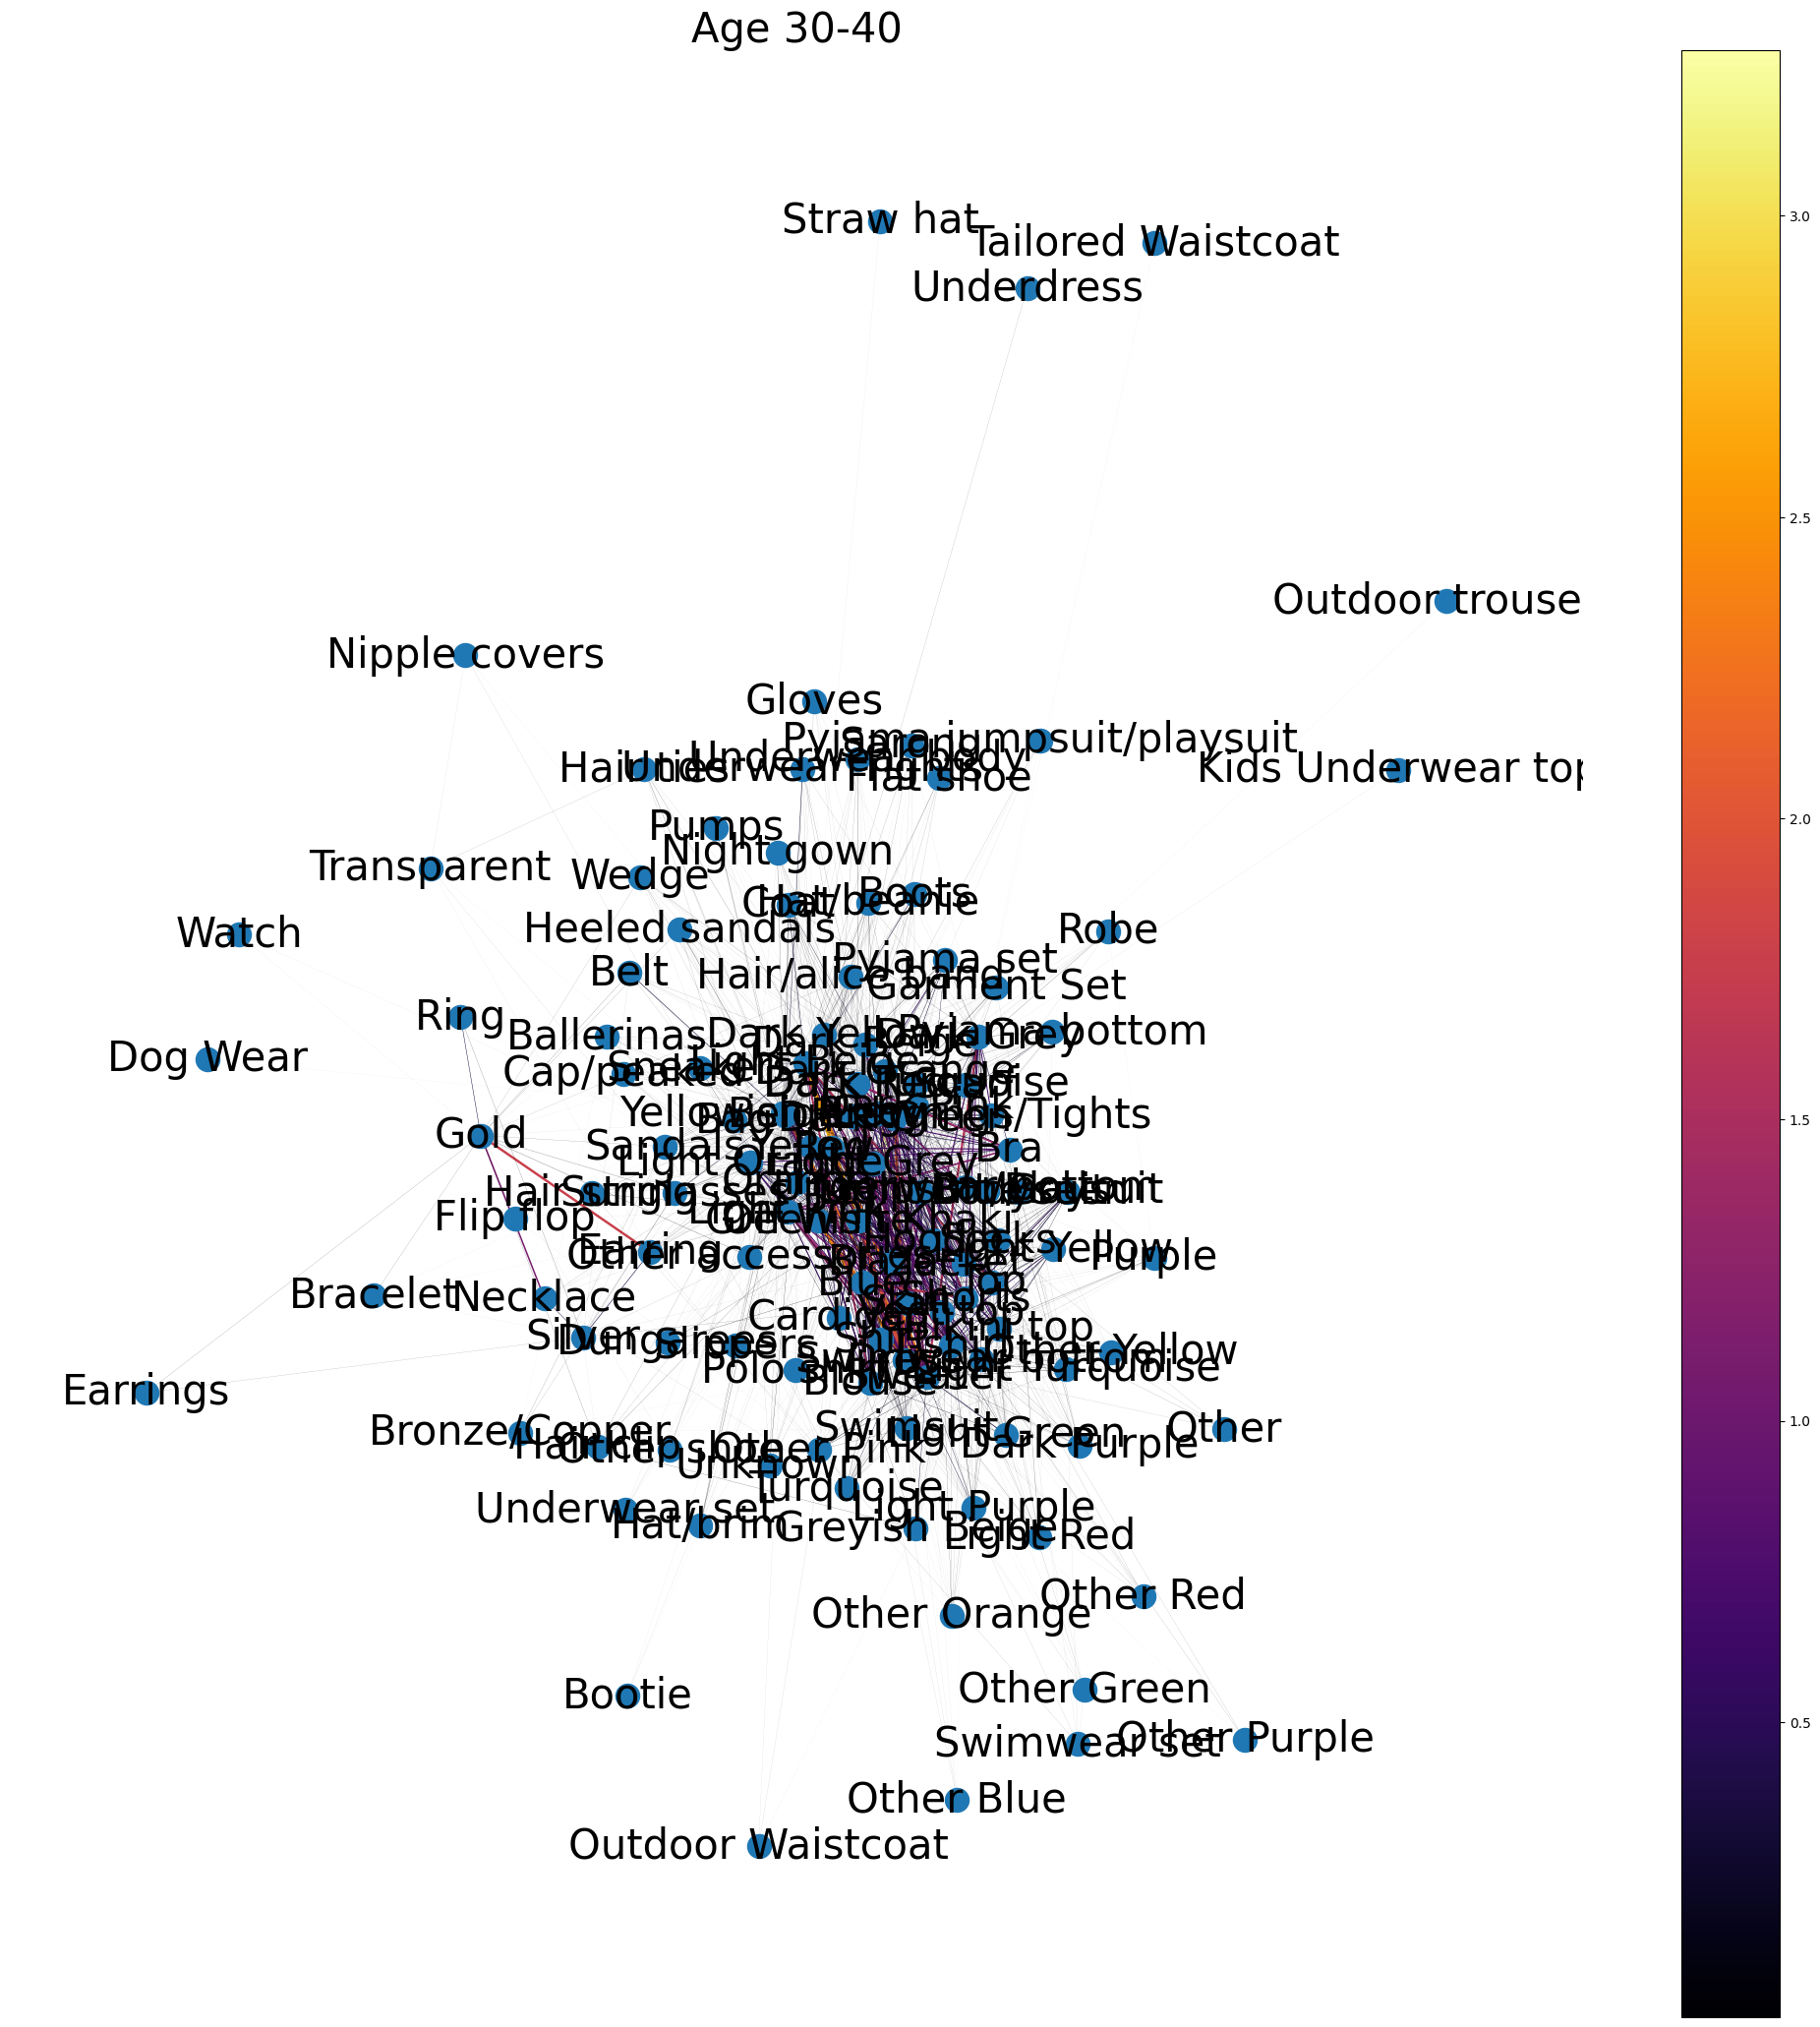

In [417]:



figure(figsize=(20,20))
cmap = plt.cm.inferno
f=nx.draw(G,width=support,with_labels=True,edge_color=support,edge_cmap=cmap,font_size=30)
#f=nx.draw(G,width=support,with_labels=True,font_size=30)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Age 30-40',fontsize=30)
plt.show()

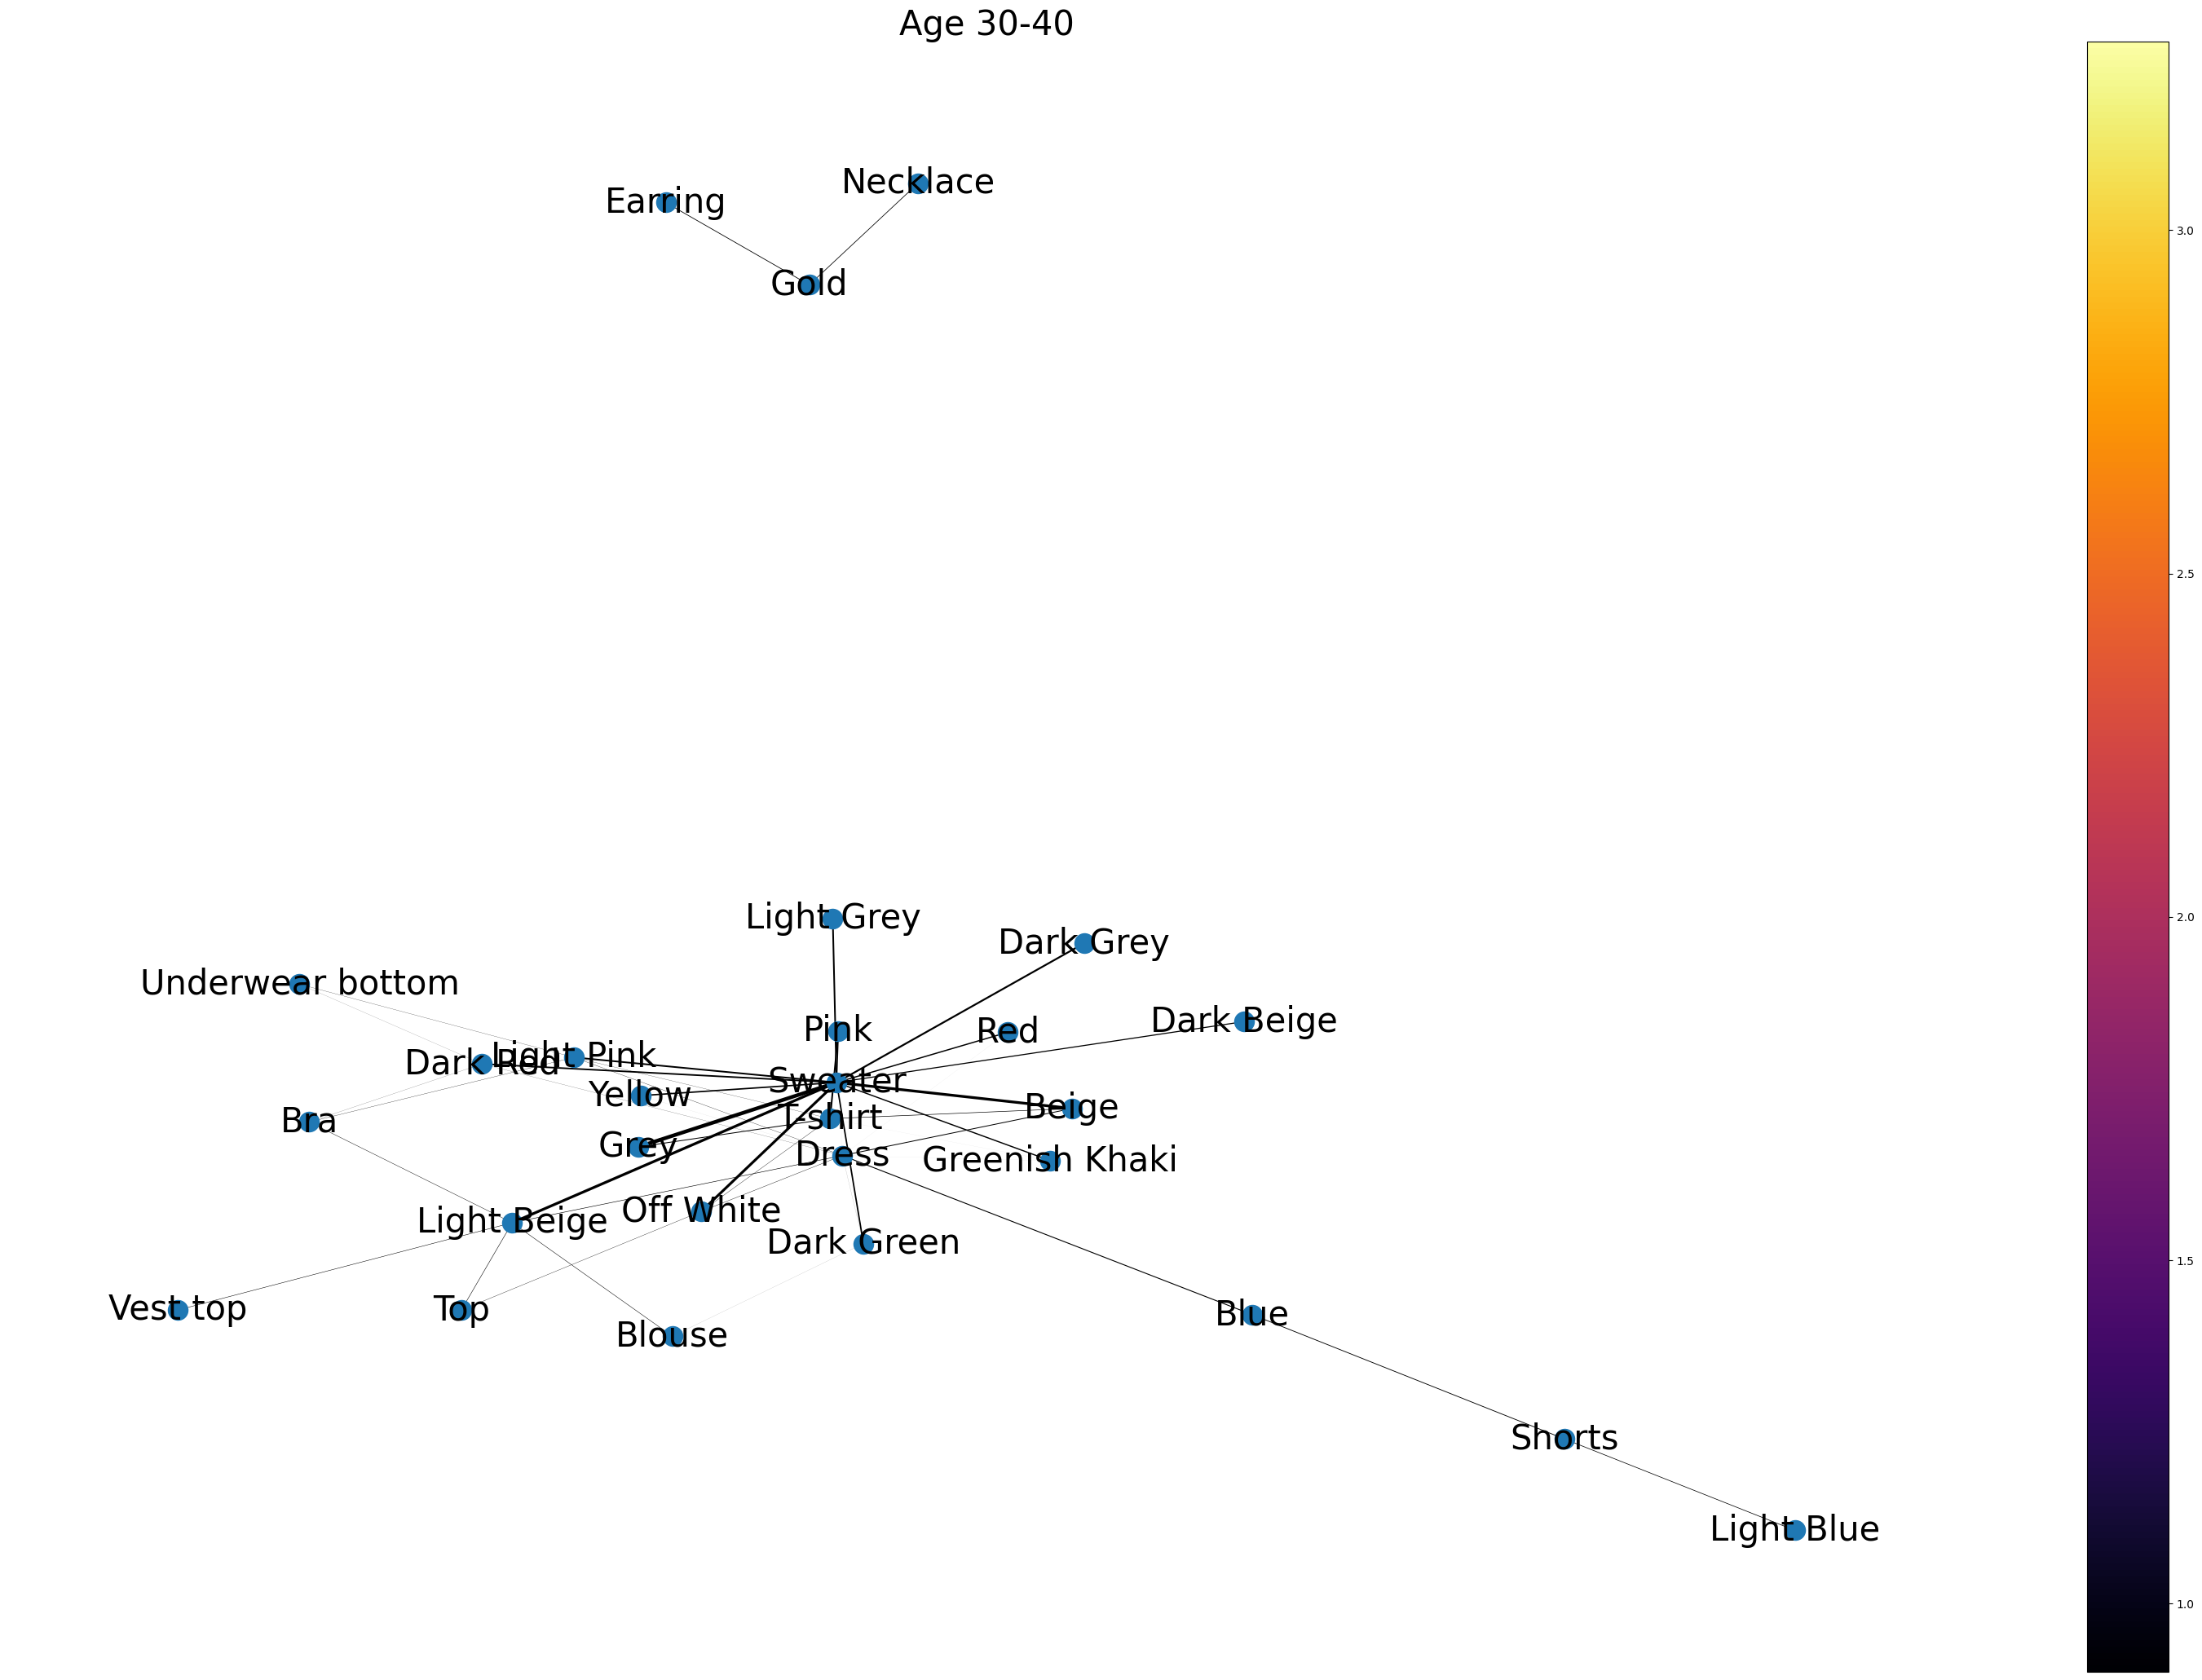

In [418]:
figure(figsize=(30,20))
cmap = plt.cm.inferno
select_edges=((u, v, e) for u,v,e in G.edges(data=True) if e['support'] >=0.9)
H = nx.Graph(select_edges)
f=nx.draw(H,with_labels=True,width=support,font_size=30)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin = .9, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Age 30-40',fontsize=30)
plt.show()

In [419]:
apo_rules(freq30_40).sort_values('confidence', ascending = False)

antecedents  \
9392  (Swimwear bottom_Light Yellow, Bikini top_Red,...   
1470     (Swimwear bottom_Light Orange, Bikini top_Red)   
2220  (Swimwear bottom_Light Orange, Bikini top_Red,...   
5672  (Swimwear bottom_Light Blue, Bikini top_Light ...   
6057  (Swimwear bottom_Yellow, Bikini top_Light Oran...   
...                                                 ...   
9246                                     (Sweater_Grey)   
9580                                     (Sweater_Grey)   
9543                                     (Sweater_Grey)   
9492                                     (Sweater_Grey)   
9554                                     (Sweater_Grey)   

                            consequents  antecedent support  \
9392              (Swimwear bottom_Red)            0.000103   
1470          (Bikini top_Light Orange)            0.000276   
2220          (Bikini top_Light Orange)            0.000224   
5672            (Bikini top_Light Blue)            0.000140   
6057     (Swimwear bottom_Light Orange)            0.000135   
...                                 ...                 ...   
9246                   (Earring_Silver)            0.032748   
9580                 (Bra_Light Orange)            0.032748   
9543  (Sweater_Red, Sweater_Dark Green)            0.032748   
9492                 (Shorts_Dark Grey)            0.032748   
9554                  (Shirt_Off White)            0.032748   

      consequent support   support  confidence        lift  leverage  \
9392            0.007737  0.000103    1.000000  129.244565  0.000102   
1470            0.003593  0.000271    0.983051  273.603888  0.000270   
2220            0.003593  0.000220    0.979167  272.522838  0.000219   
5672            0.004149  0.000135    0.966667  232.989527  0.000135   
6057            0.003322  0.000131    0.965517  290.645133  0.000130   
...                  ...       ...         ...         ...       ...   
9246            0.004168  0.000103    0.003139    0.753138 -0.000034   
9580            0.007205  0.000103    0.003139    0.435667 -0.000133   
9543            0.000509  0.000103    0.003139    6.163292  0.000086   
9492            0.007733  0.000103    0.003139    0.405921 -0.000150   
9554            0.002140  0.000103    0.003139    1.466810  0.000033   

      conviction  
9392         inf  
1470   58.788015  
2220   47.827537  
5672   29.875531  
6057   28.903663  
...          ...  
9246    0.998968  
9580    0.995921  
9543    1.002638  
9492    0.995392  
9554    1.001002  

[9852 rows x 9 columns]

## Age group 40-50

In [420]:
apo=aprio(df40_50,0.001)

In [421]:
apo

support                                     itemsets  length
266  0.037354                               (Sweater_Grey)       1
101  0.026127                          (Dress_Light Beige)       1
110  0.022162                            (Dress_Off White)       1
277  0.021972                          (Sweater_Off White)       1
209  0.021747                                (Shorts_Blue)       1
..        ...                                          ...     ...
376  0.001031                       (Vest top_Dark Yellow)       1
225  0.001016                     (Shorts_Yellowish Brown)       1
121  0.001016                    (Hair clip_Greyish Beige)       1
399  0.001010  (Swimwear bottom_Orange, Bikini top_Orange)       2
56   0.001010                             (Bra_Dark Green)       1

[435 rows x 3 columns]

In [422]:
apo[apo.length>=2]

support                                           itemsets  length
401  0.005791              (Swimwear bottom_Red, Bikini top_Red)       2
392  0.004821  (Bikini top_Dark Green, Swimwear bottom_Dark G...       2
416  0.004303                   (Shorts_Light Blue, Shorts_Blue)       2
403  0.003954          (Underwear bottom_Dark Red, Bra_Dark Red)       2
395  0.003554  (Swimwear bottom_Light Blue, Bikini top_Light ...       2
391  0.002698            (Bikini top_Blue, Swimwear bottom_Blue)       2
398  0.002534  (Swimwear bottom_Off White, Bikini top_Off White)       2
393  0.002441    (Swimwear bottom_Dark Red, Bikini top_Dark Red)       2
404  0.002375      (Underwear bottom_Light Pink, Bra_Light Pink)       2
413  0.002349                    (Shorts_Dark Grey, Shorts_Blue)       2
424  0.002293                  (Sweater_Grey, Sweater_Dark Grey)       2
419  0.002144                      (Sweater_Grey, Sweater_Beige)       2
427  0.002046                (Sweater_Grey, Sweater_Light Beige)       2
406  0.002031                    (Underwear bottom_Red, Bra_Red)       2
409  0.001923               (Dress_Off White, Dress_Light Beige)       2
396  0.001913  (Swimwear bottom_Light Orange, Bikini top_Ligh...       2
402  0.001852        (Swimwear bottom_Yellow, Bikini top_Yellow)       2
417  0.001739              (Shorts_Light Blue, Shorts_Dark Grey)       2
428  0.001682                 (Sweater_Light Grey, Sweater_Grey)       2
430  0.001662                  (Sweater_Grey, Sweater_Off White)       2
415  0.001657                         (Shorts_Blue, Shorts_Grey)       2
397  0.001585  (Swimwear bottom_Light Yellow, Bikini top_Ligh...       2
420  0.001503               (Sweater_Light Beige, Sweater_Beige)       2
390  0.001416          (Swimwear bottom_Beige, Bikini top_Beige)       2
423  0.001395                 (Sweater_Grey, Sweater_Dark Green)       2
429  0.001369                 (Sweater_Light Pink, Sweater_Grey)       2
405  0.001359                  (Bra_Pink, Underwear bottom_Pink)       2
418  0.001344                   (Shorts_Light Blue, Shorts_Grey)       2
425  0.001328                   (Sweater_Grey, Sweater_Dark Red)       2
407  0.001303          (Dress_Light Beige, Dress_Greenish Khaki)       2
394  0.001282  (Bikini top_Light Beige, Swimwear bottom_Light...       2
421  0.001262                 (Sweater_Off White, Sweater_Beige)       2
408  0.001236            (Dress_Off White, Dress_Greenish Khaki)       2
431  0.001226                        (Sweater_Grey, Sweater_Red)       2
432  0.001221                     (Sweater_Grey, Sweater_Yellow)       2
410  0.001164                     (Dress_Light Beige, Dress_Red)       2
412  0.001149                      (Necklace_Gold, Earring_Gold)       2
426  0.001123             (Sweater_Grey, Sweater_Greenish Khaki)       2
411  0.001118                (Dress_Off White, Dress_Light Pink)       2
400  0.001092  (Bikini top_Other Pink, Swimwear bottom_Other ...       2
433  0.001092           (Sweater_Off White, Sweater_Light Beige)       2
434  0.001082             (T-shirt_Greenish Khaki, T-shirt_Grey)       2
422  0.001046          (Sweater_Light Beige, Sweater_Dark Beige)       2
414  0.001041               (Shorts_Greenish Khaki, Shorts_Blue)       2
399  0.001010        (Swimwear bottom_Orange, Bikini top_Orange)       2

In [423]:
freq40_50=freqitm(df40_50,0.0001)

In [424]:
freq40_50

support                                       itemsets  length
5     0.037354                                 (Sweater_Grey)       1
13    0.026127                            (Dress_Light Beige)       1
77    0.022162                              (Dress_Off White)       1
98    0.021972                            (Sweater_Off White)       1
30    0.021747                                  (Shorts_Blue)       1
...        ...                                            ...     ...
3671  0.000103       (Cardigan_Dark Grey, Sweater_Light Pink)       2
2084  0.000103     (Jacket_Greenish Khaki, Blouse_Dark Green)       2
2086  0.000103       (Bra_Light Orange, Dress_Greenish Khaki)       2
2093  0.000103  (Bra_Light Orange, Underwear bottom_Dark Red)       2
2859  0.000103         (Dress_Light Blue, Blouse_Light Beige)       2

[3883 rows x 3 columns]

In [425]:
freq2items40_50=newcol(freq40_50)

In [426]:
freq2items40_50.support=freq2items40_50.support*100
vmax=freq2items40_50.support.max()
vmin=freq2items40_50.support.min()

In [427]:
print(vmin)
print(vmax)

0.01025788318322631
3.7354081611718604


In [428]:
G=nx.Graph()

In [429]:
G=nx.from_pandas_edgelist(freq2items40_50,source='prod_name',target='pattern', edge_attr='support')
G.edges(data=True)

EdgeDataView([('Sweater', 'Grey', {'support': 3.7354081611718604}), ('Sweater', 'Off White', {'support': 2.1972385778470755}), ('Sweater', 'Beige', {'support': 2.099788687606426}), ('Sweater', 'Light Beige', {'support': 2.085427651149909}), ('Sweater', 'Dark Grey', {'support': 1.7689719549473772}), ('Sweater', 'Light Pink', {'support': 1.4612354594505879}), ('Sweater', 'Light Grey', {'support': 1.453542047063168}), ('Sweater', 'Yellow', {'support': 1.4166136676035535}), ('Sweater', 'Red', {'support': 1.310444576657161}), ('Sweater', 'Dark Green', {'support': 1.2960835402006443}), ('Sweater', 'Dark Red', {'support': 1.264796996491804}), ('Sweater', 'Greenish Khaki', {'support': 1.051945920439858}), ('Sweater', 'Dark Beige', {'support': 0.9021808259647539}), ('Sweater', 'Pink', {'support': 0.8401206327062347}), ('Sweater', 'Yellowish Brown', {'support': 0.7113841987567445}), ('Sweater', 'Light Orange', {'support': 0.6836879141620334}), ('Sweater', 'Blue', {'support': 0.45545001333524815}

In [430]:
edges,support=zip(*nx.get_edge_attributes(G,'support').items())

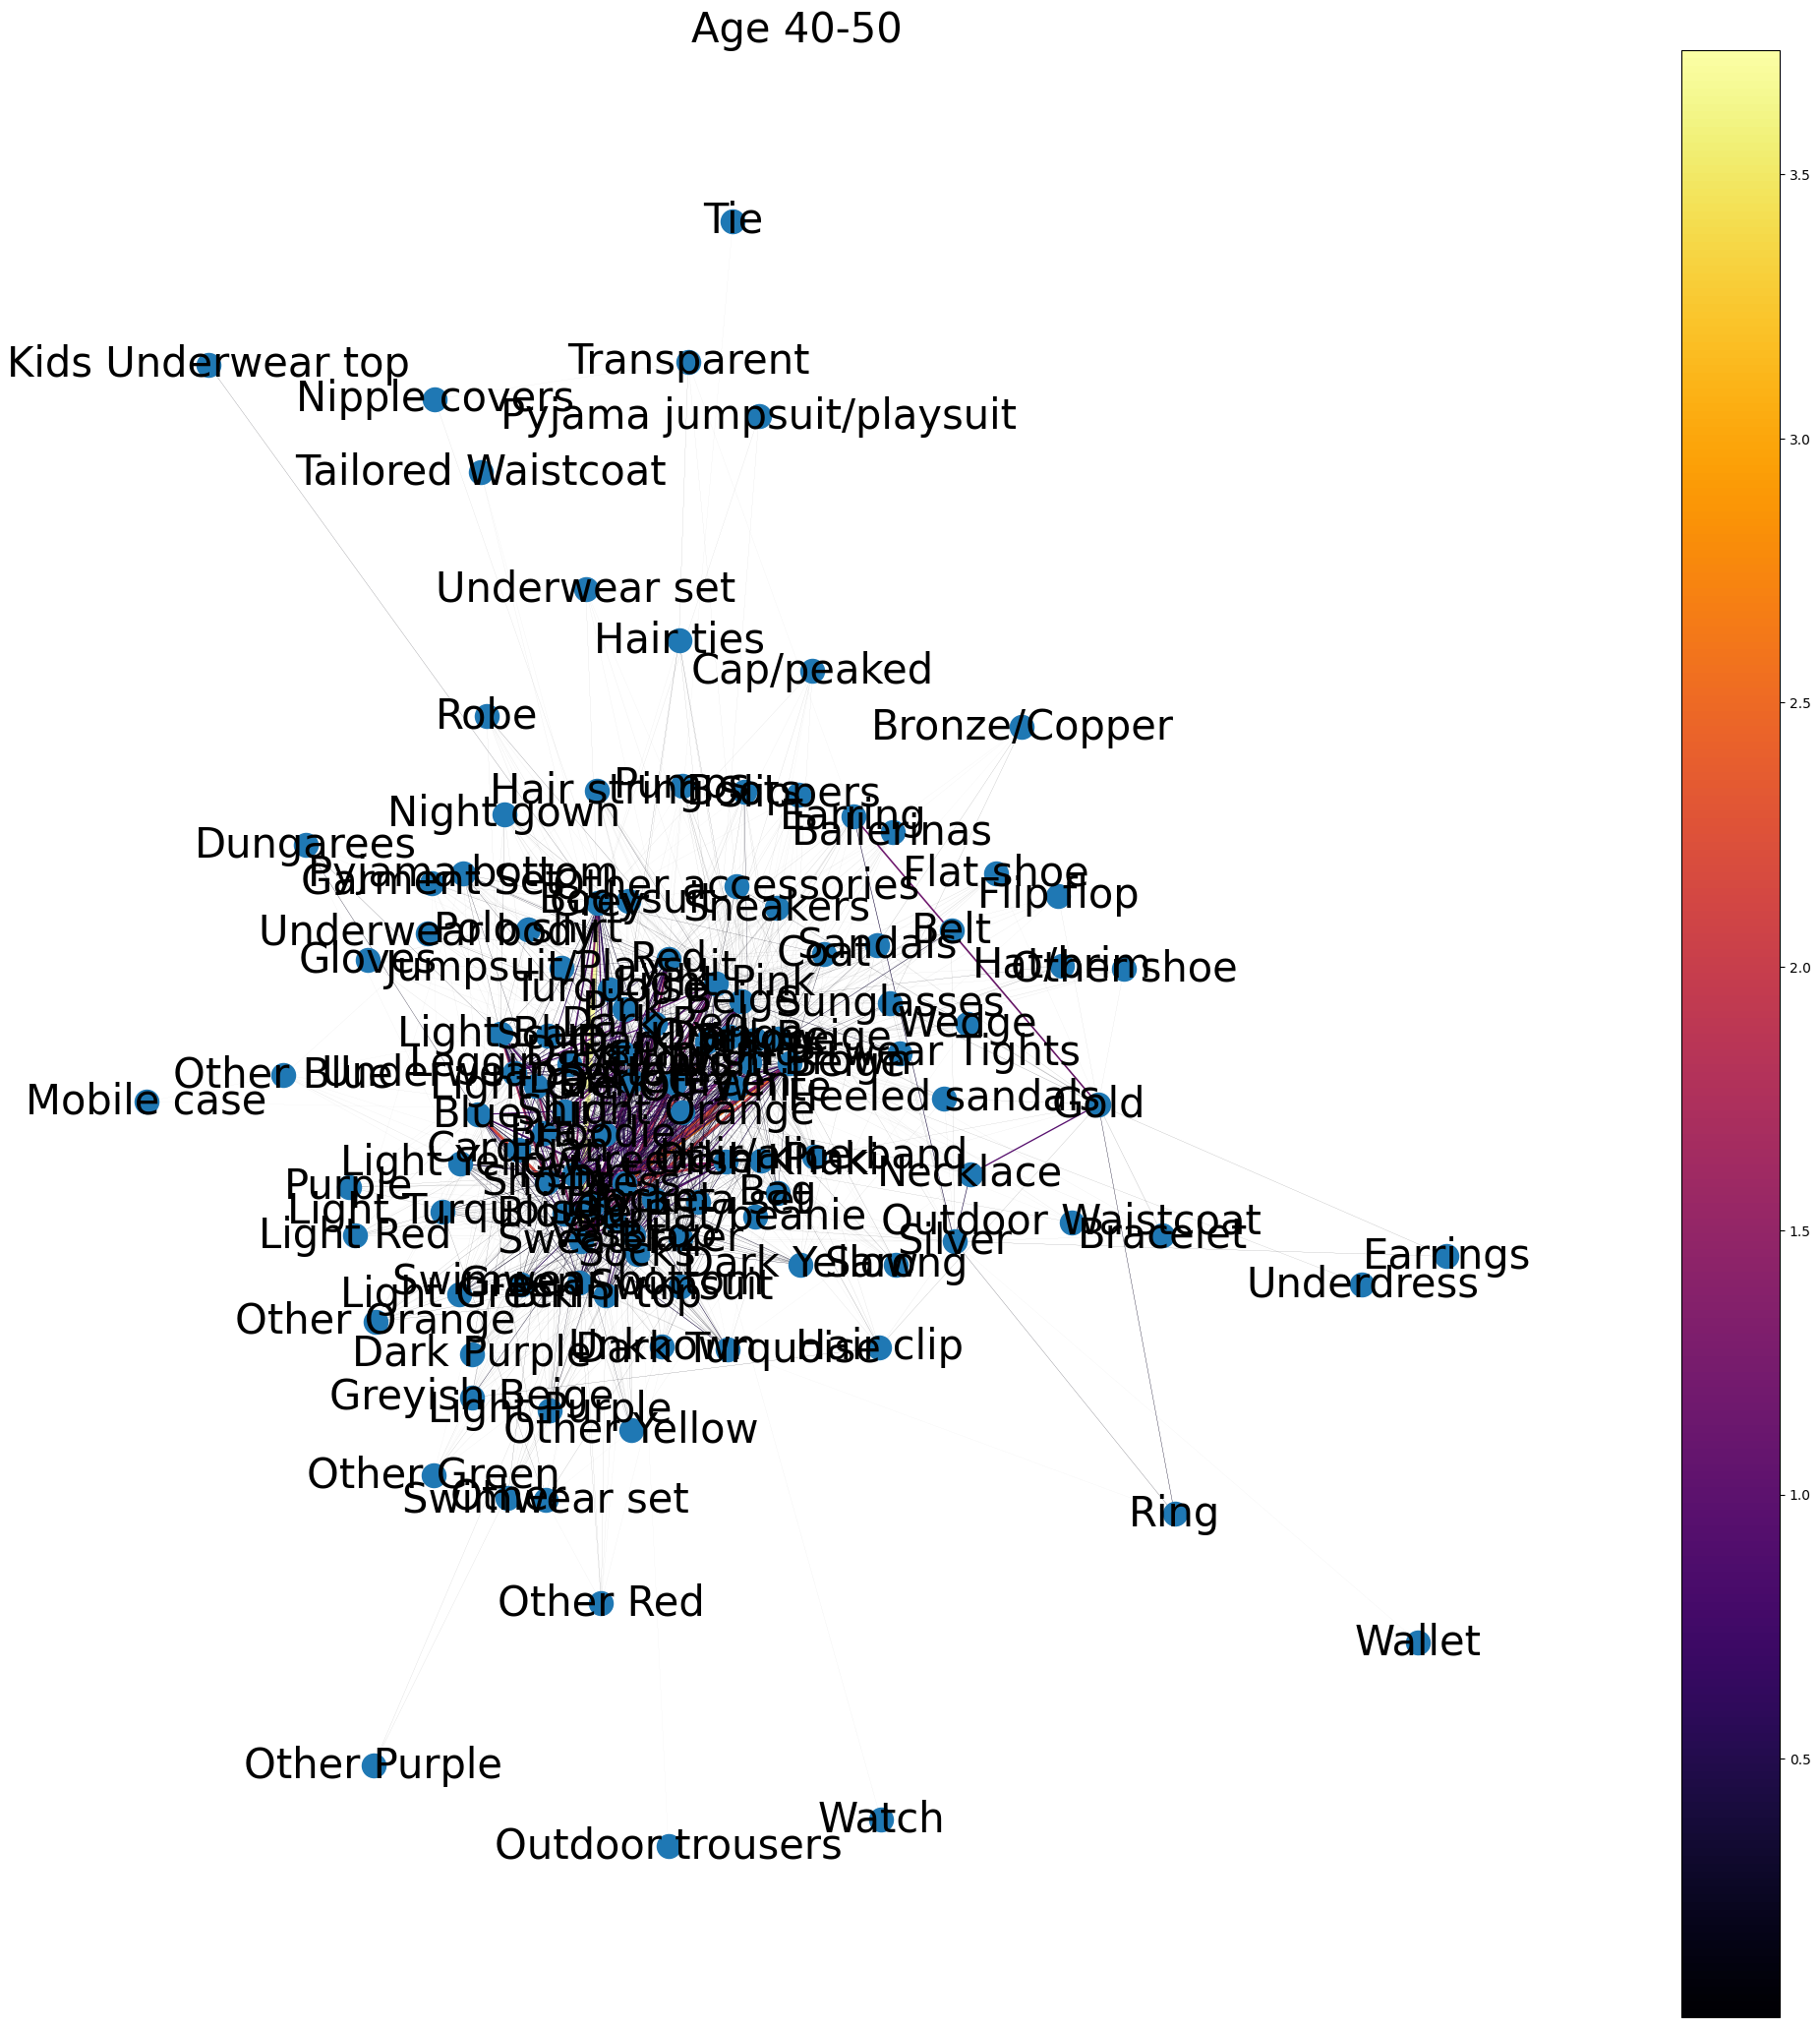

In [431]:


from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib as mpl
#ax = plt.gca()
fig=figure(figsize=(20,20))
#fig.title('Age 40-50')

cmap = plt.cm.inferno
f=nx.draw(G,width=support,with_labels=True,edge_color=support,edge_cmap=cmap,font_size=30)
#f=nx.draw(G,width=support,with_labels=True,font_size=30)
plt.title('Age')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.title('Age 40-50',fontsize=30)
plt.show()

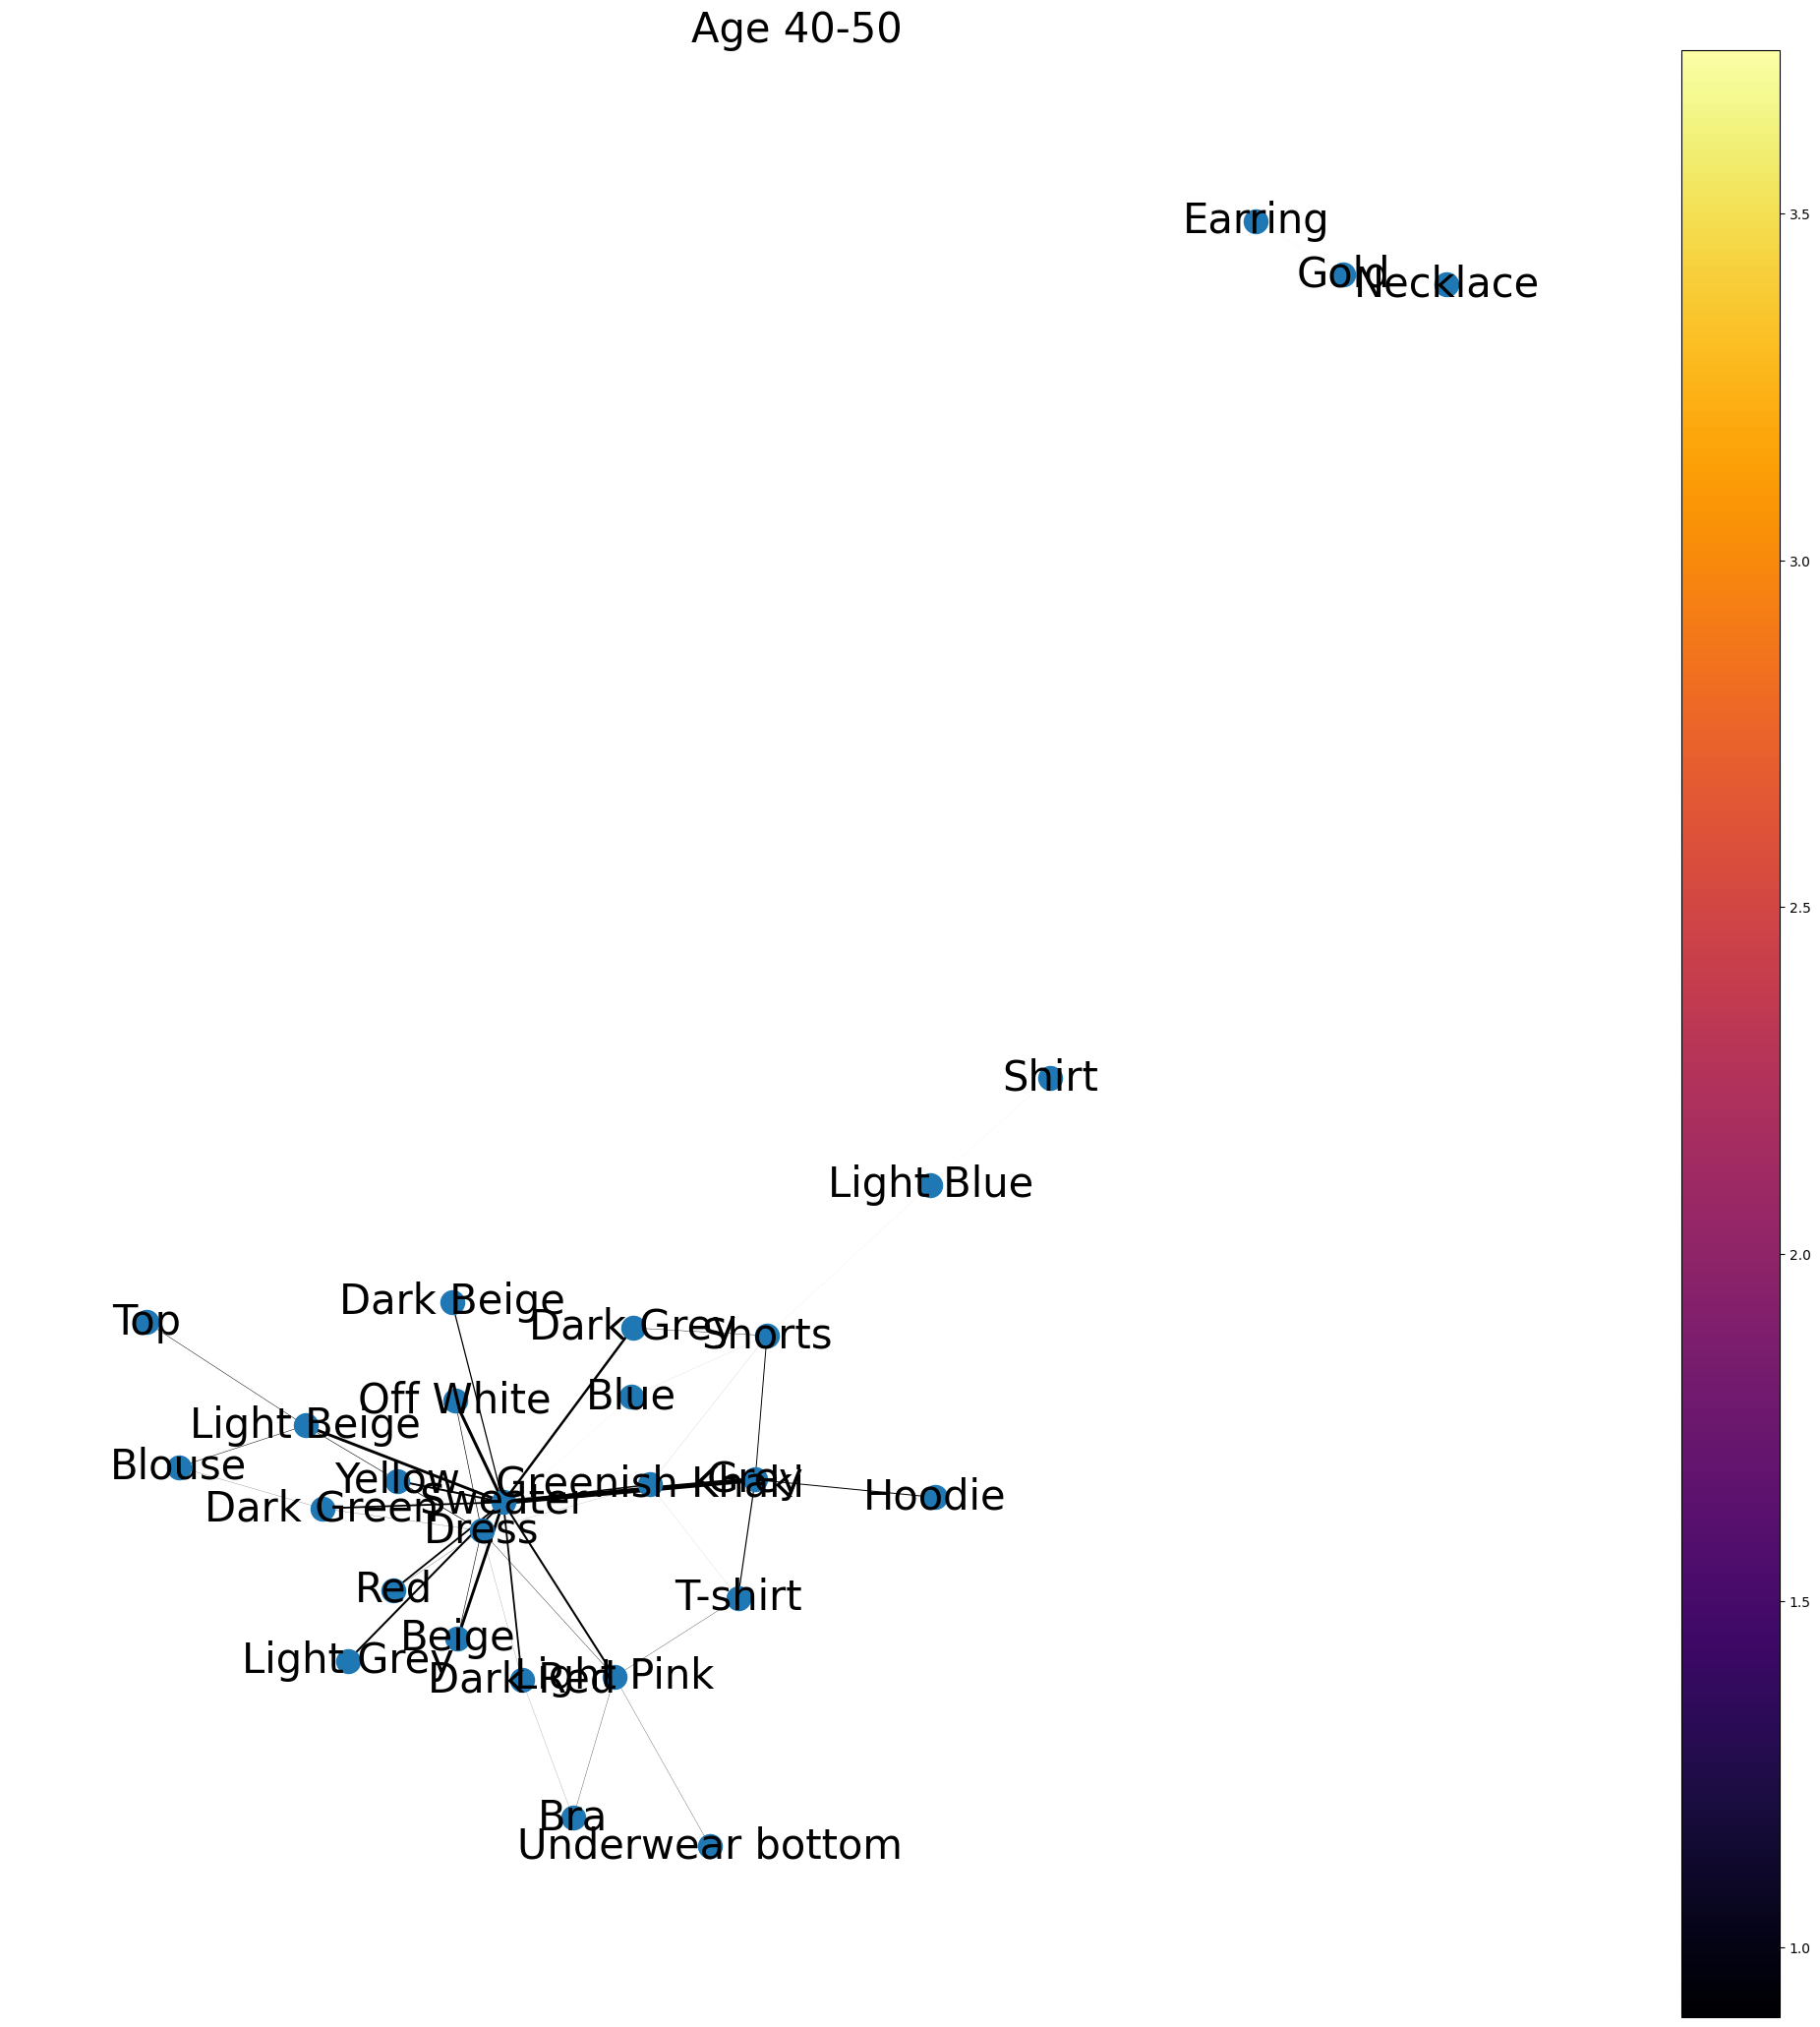

In [432]:
figure(figsize=(20,20))
cmap = plt.cm.inferno
select_edges=((u, v, e) for u,v,e in G.edges(data=True) if e['support'] >=0.9)
H = nx.Graph(select_edges)
f=nx.draw(H,with_labels=True,width=support,font_size=30)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin = .9, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Age 40-50',fontsize=30)
plt.show()

In [433]:
apo_rules(freq40_50).sort_values('confidence', ascending = False)

antecedents  \
5437  (Swimwear bottom_Light Yellow, Bikini top_Ligh...   
5943  (Swimwear bottom_Light Blue, Swimwear bottom_L...   
1578  (Swimwear bottom_Light Blue, Bikini top_Dark G...   
561   (Bikini top_Dark Green, Bikini top_Red, Swimwe...   
2172  (Swimwear bottom_Yellow, Swimwear bottom_Red, ...   
...                                                 ...   
6105                                     (Sweater_Grey)   
6063                                     (Sweater_Grey)   
6022                                     (Sweater_Grey)   
5807                                     (Sweater_Grey)   
6055                                     (Sweater_Grey)   

                                   consequents  antecedent support  \
5437                 (Bikini top_Light Yellow)            0.000108   
5943                 (Bikini top_Light Yellow)            0.000103   
1578                   (Bikini top_Light Blue)            0.000221   
561                      (Swimwear bottom_Red)            0.000405   
2172                       (Bikini top_Yellow)            0.000190   
...                                        ...                 ...   
6105  (Sweater_Light Grey, Sweater_Dark Green)            0.037354   
6063              (Sweater_Red, Sweater_Beige)            0.037354   
6022                       (Jacket_Light Blue)            0.037354   
5807       (Sweater_Light Pink, Sweater_Beige)            0.037354   
6055    (Sweater_Light Grey, Sweater_Dark Red)            0.037354   

      consequent support   support  confidence        lift  leverage  \
5437            0.002164  0.000108    1.000000  462.018957  0.000107   
5943            0.002164  0.000103    1.000000  462.018957  0.000102   
1578            0.004590  0.000215    0.976744  212.779628  0.000214   
561             0.007565  0.000395    0.974684  128.837966  0.000392   
2172            0.002754  0.000185    0.972973  353.263476  0.000184   
...                  ...       ...         ...         ...       ...   
6105            0.000472  0.000103    0.002746    5.819747  0.000085   
6063            0.000446  0.000103    0.002746    6.154215  0.000086   
6022            0.004483  0.000103    0.002746    0.612605 -0.000065   
5807            0.000636  0.000103    0.002746    4.317877  0.000079   
6055            0.000559  0.000103    0.002746    4.912080  0.000082   

      conviction  
5437         inf  
5943         inf  
1578   42.802613  
561    39.201175  
2172   36.898093  
...          ...  
6105    1.002281  
6063    1.002306  
6022    0.998259  
5807    1.002116  
6055    1.002193  

[6300 rows x 9 columns]

## Age group above 40

In [434]:
apo=aprio(df40above,0.001)

In [435]:
apo

support                             itemsets  length
258  0.034811                       (Sweater_Grey)       1
106  0.027813                  (Dress_Light Beige)       1
115  0.023943                    (Dress_Off White)       1
260  0.023397                (Sweater_Light Beige)       1
246  0.023200                      (Sweater_Beige)       1
..        ...                                  ...     ...
344  0.001022             (Underwear bottom_Beige)       1
397  0.001007  (Dress_Off White, Dress_Light Pink)       2
396  0.001007       (Dress_Light Beige, Dress_Red)       2
57   0.001007                          (Bra_Beige)       1
171  0.001007           (Pyjama bottom_Light Blue)       1

[415 rows x 3 columns]

In [436]:
apo[apo.length>=2]

support                                           itemsets  length
386  0.004786              (Swimwear bottom_Red, Bikini top_Red)       2
378  0.004278  (Bikini top_Dark Green, Swimwear bottom_Dark G...       2
388  0.003160          (Underwear bottom_Dark Red, Bra_Dark Red)       2
382  0.003008  (Swimwear bottom_Light Blue, Bikini top_Light ...       2
400  0.002946                   (Shorts_Light Blue, Shorts_Blue)       2
377  0.002188            (Bikini top_Blue, Swimwear bottom_Blue)       2
380  0.002140    (Swimwear bottom_Dark Red, Bikini top_Dark Red)       2
385  0.002115  (Bikini top_Off White, Swimwear bottom_Off White)       2
407  0.002027                  (Sweater_Grey, Sweater_Dark Grey)       2
389  0.001928      (Underwear bottom_Light Pink, Bra_Light Pink)       2
395  0.001917               (Dress_Light Beige, Dress_Off White)       2
410  0.001913                (Sweater_Grey, Sweater_Light Beige)       2
387  0.001826        (Swimwear bottom_Yellow, Bikini top_Yellow)       2
402  0.001823                      (Sweater_Grey, Sweater_Beige)       2
383  0.001807  (Swimwear bottom_Light Orange, Bikini top_Ligh...       2
391  0.001674                    (Underwear bottom_Red, Bra_Red)       2
403  0.001619               (Sweater_Light Beige, Sweater_Beige)       2
398  0.001603                    (Shorts_Dark Grey, Shorts_Blue)       2
411  0.001524                 (Sweater_Light Grey, Sweater_Grey)       2
413  0.001447                  (Sweater_Grey, Sweater_Off White)       2
376  0.001305          (Swimwear bottom_Beige, Bikini top_Beige)       2
404  0.001299                 (Sweater_Off White, Sweater_Beige)       2
392  0.001251          (Dress_Light Beige, Dress_Greenish Khaki)       2
384  0.001249  (Swimwear bottom_Light Yellow, Bikini top_Ligh...       2
409  0.001241                   (Sweater_Grey, Sweater_Dark Red)       2
381  0.001236  (Bikini top_Light Beige, Swimwear bottom_Light...       2
412  0.001197                 (Sweater_Light Pink, Sweater_Grey)       2
390  0.001172                  (Bra_Pink, Underwear bottom_Pink)       2
406  0.001155                 (Sweater_Grey, Sweater_Dark Green)       2
401  0.001153              (Shorts_Light Blue, Shorts_Dark Grey)       2
414  0.001141           (Sweater_Off White, Sweater_Light Beige)       2
405  0.001128          (Sweater_Light Beige, Sweater_Dark Beige)       2
393  0.001124            (Dress_Off White, Dress_Greenish Khaki)       2
379  0.001068  (Swimwear bottom_Dark Grey, Bikini top_Dark Grey)       2
399  0.001051                         (Shorts_Blue, Shorts_Grey)       2
408  0.001043           (Sweater_Dark Grey, Sweater_Light Beige)       2
394  0.001033              (Dress_Light Beige, Dress_Light Pink)       2
397  0.001007                (Dress_Off White, Dress_Light Pink)       2
396  0.001007                     (Dress_Light Beige, Dress_Red)       2

In [437]:
freq40above=freqitm(df40above,0.0001)

In [438]:
freq40above

support                                           itemsets  length
43    0.034811                                     (Sweater_Grey)       1
71    0.027813                                (Dress_Light Beige)       1
50    0.023943                                  (Dress_Off White)       1
10    0.023397                              (Sweater_Light Beige)       1
11    0.023200                                    (Sweater_Beige)       1
...        ...                                                ...     ...
2891  0.000100                (Vest top_Pink, Vest top_Off White)       2
1431  0.000100                     (Dress_Red, Blouse_Dark Green)       2
1694  0.000100       (Underwear bottom_Dark Red, Bra_Light Beige)       2
1432  0.000100              (Sweater_Dark Red, Blouse_Dark Green)       2
1761  0.000100  (Bikini top_Light Beige, Swimwear bottom_Light...       3

[3138 rows x 3 columns]

In [276]:
freq2items40above=newcol(freq40above)

In [277]:
freq2items40above.support=freq2items40above.support*100
vmax=freq2items40above.support.max()
vmin=freq2items40above.support.min()

In [274]:
G=nx.Graph()

In [275]:
G=nx.from_pandas_edgelist(freq2items40above,source='prod_name',target='pattern', edge_attr='support')
G.edges(data=True)

EdgeDataView([('Sweater', 'Melange', {'support': 9.65754690110161}), ('Sweater', 'Solid', {'support': 9.342306833665639}), ('Sweater', 'Front print', {'support': 0.9320559503006136}), ('Sweater', 'Stripe', {'support': 0.9201237865759309}), ('Sweater', 'Application/3D', {'support': 0.6410651188212562}), ('Sweater', 'Jacquard', {'support': 0.637023579495154}), ('Sweater', 'Placement print', {'support': 0.5313661942556255}), ('Sweater', 'All over pattern', {'support': 0.5152000369512166}), ('Sweater', 'Colour blocking', {'support': 0.5019206934511666}), ('Sweater', 'Other structure', {'support': 0.4726676469003318}), ('Sweater', 'Embroidery', {'support': 0.44514668863211215}), ('Sweater', 'Neps', {'support': 0.24845844142847243}), ('Sweater', 'Contrast', {'support': 0.17474846229051352}), ('Sweater', 'Glittering/Metallic', {'support': 0.13952933387733737}), ('Sweater', 'Dot', {'support': 0.09430258427571767}), ('Sweater', 'Check', {'support': 0.07467225040607847}), ('Sweater', 'Sequin', {

In [255]:
edges,support=zip(*nx.get_edge_attributes(G,'support').items())

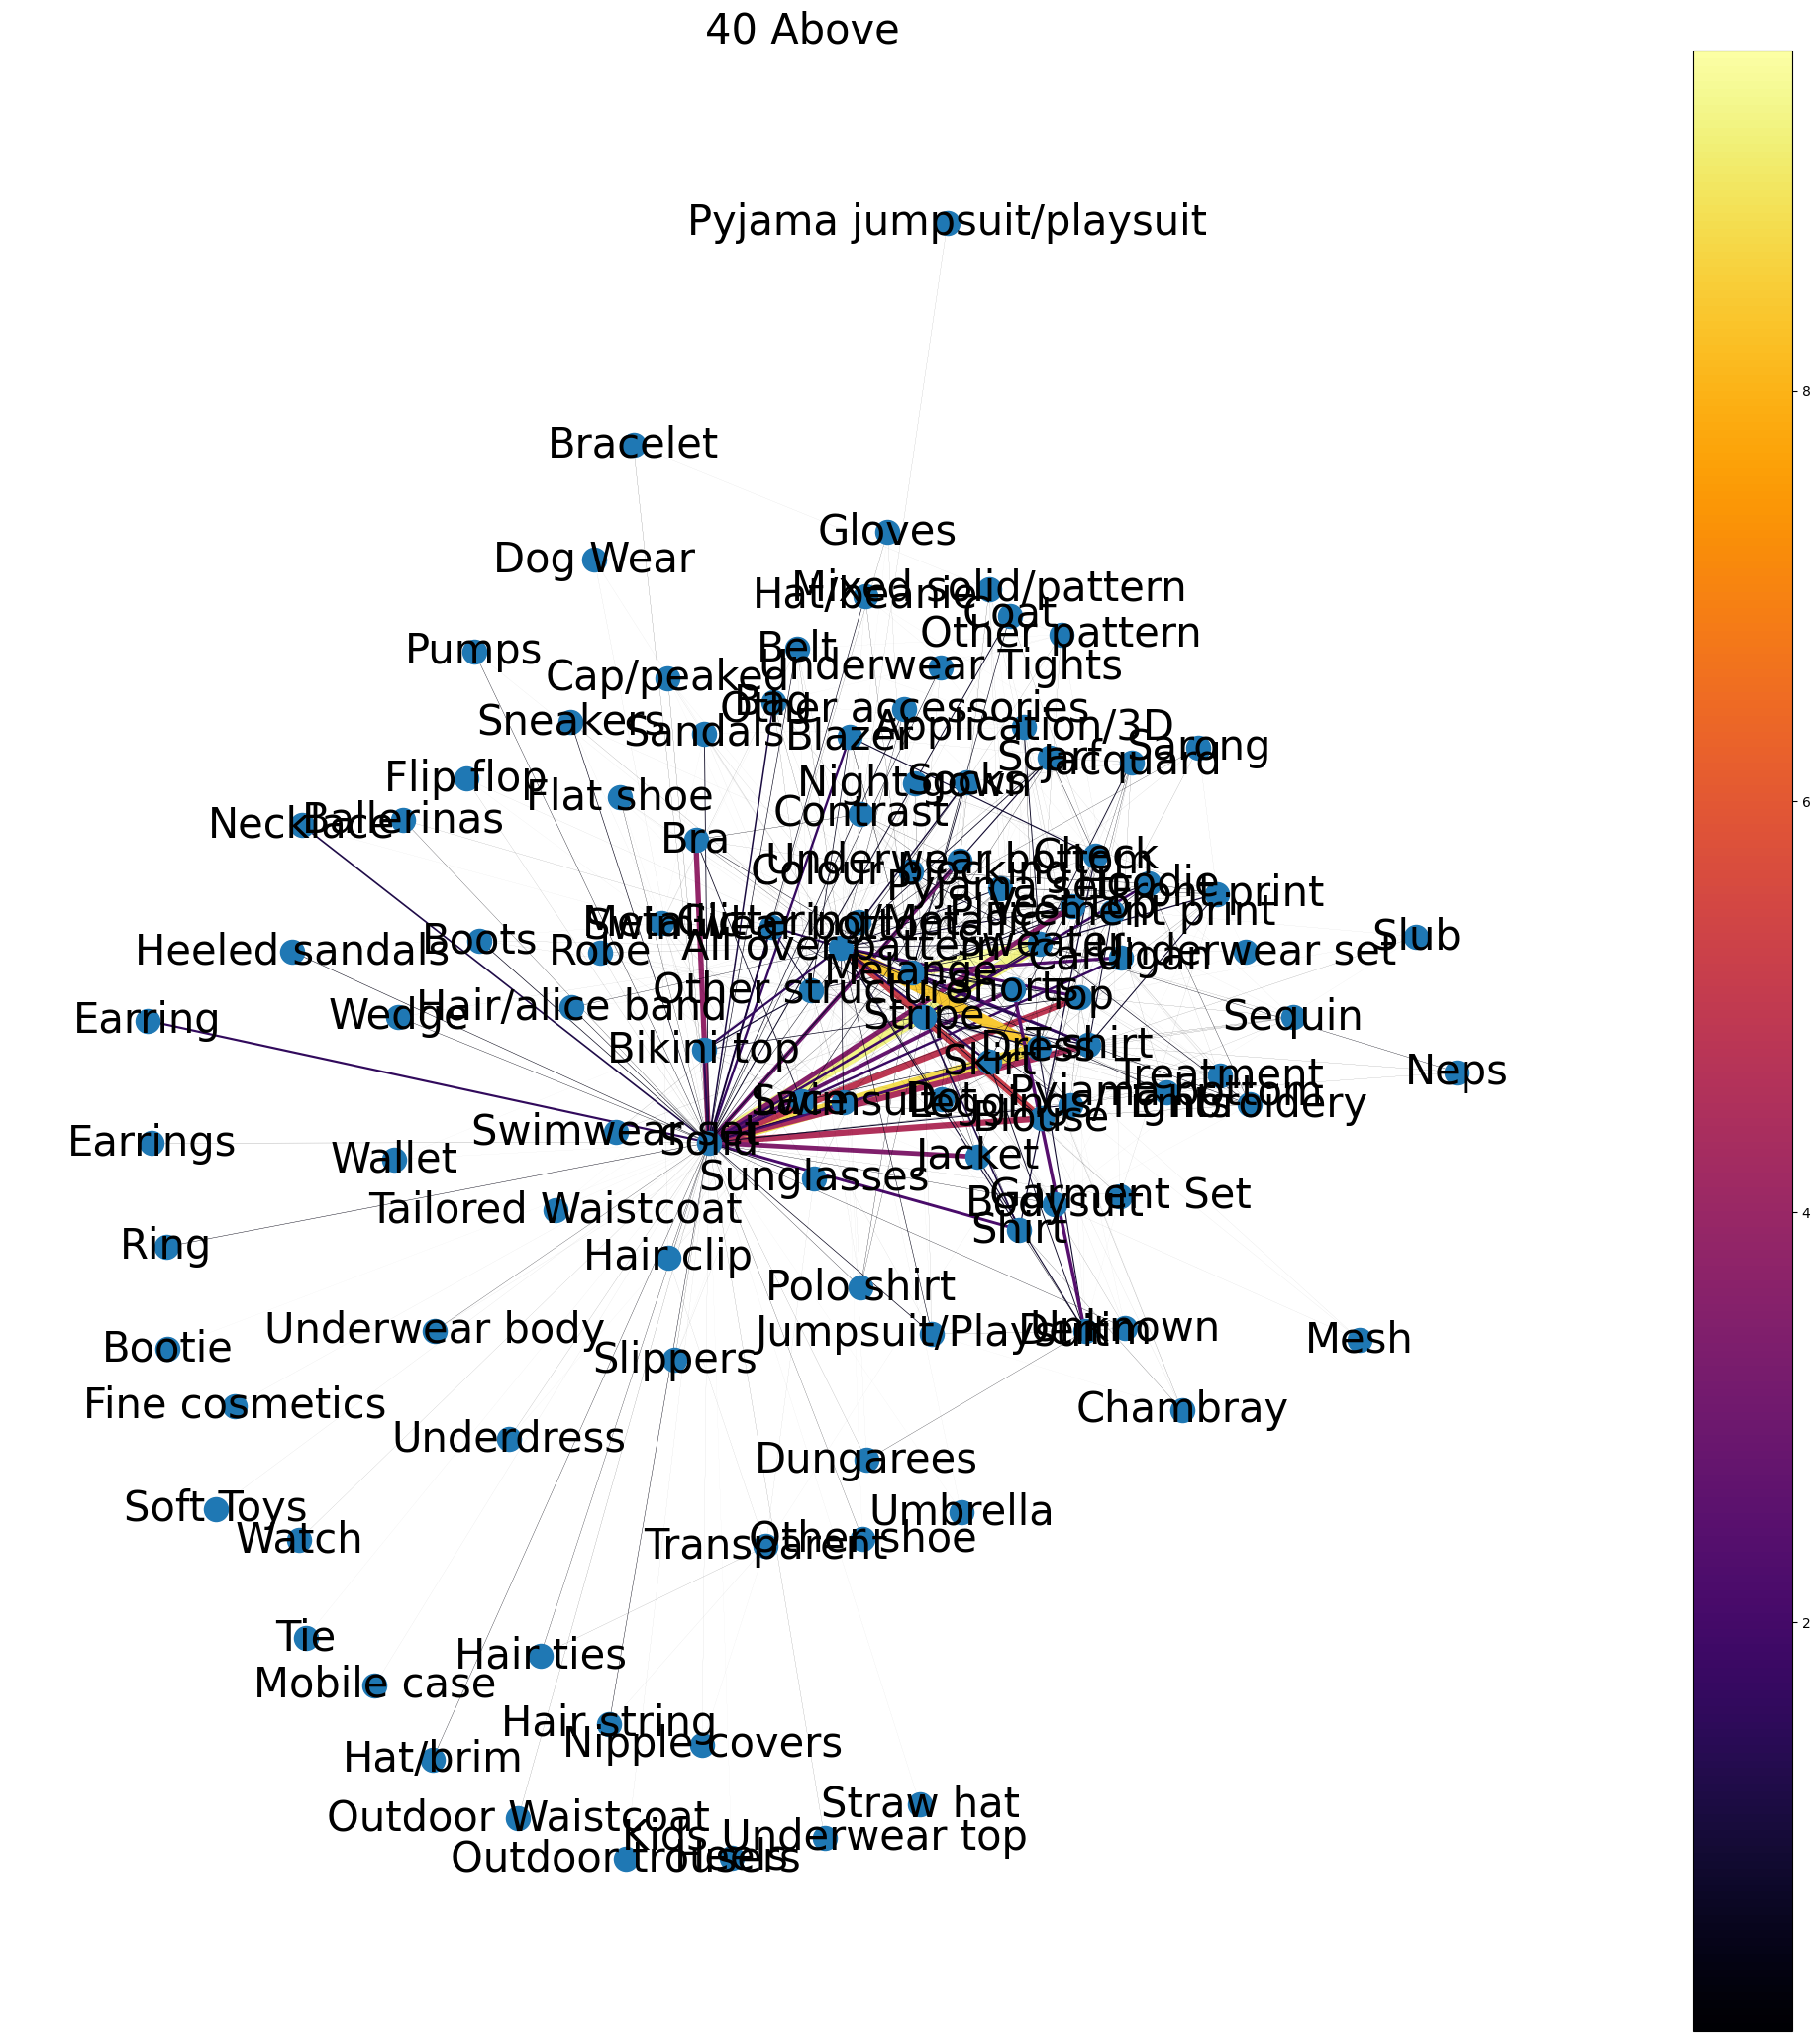

In [256]:


from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib as mpl
#ax = plt.gca()
fig=figure(figsize=(20,20))
#fig.title('Age 40-50')

cmap = plt.cm.inferno
f=nx.draw(G,width=support,with_labels=True,edge_color=support,edge_cmap=cmap,font_size=30)
#f=nx.draw(G,width=support,with_labels=True,font_size=30)
#plt.title('Age')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.title('40 Above',fontsize=30)
plt.show()

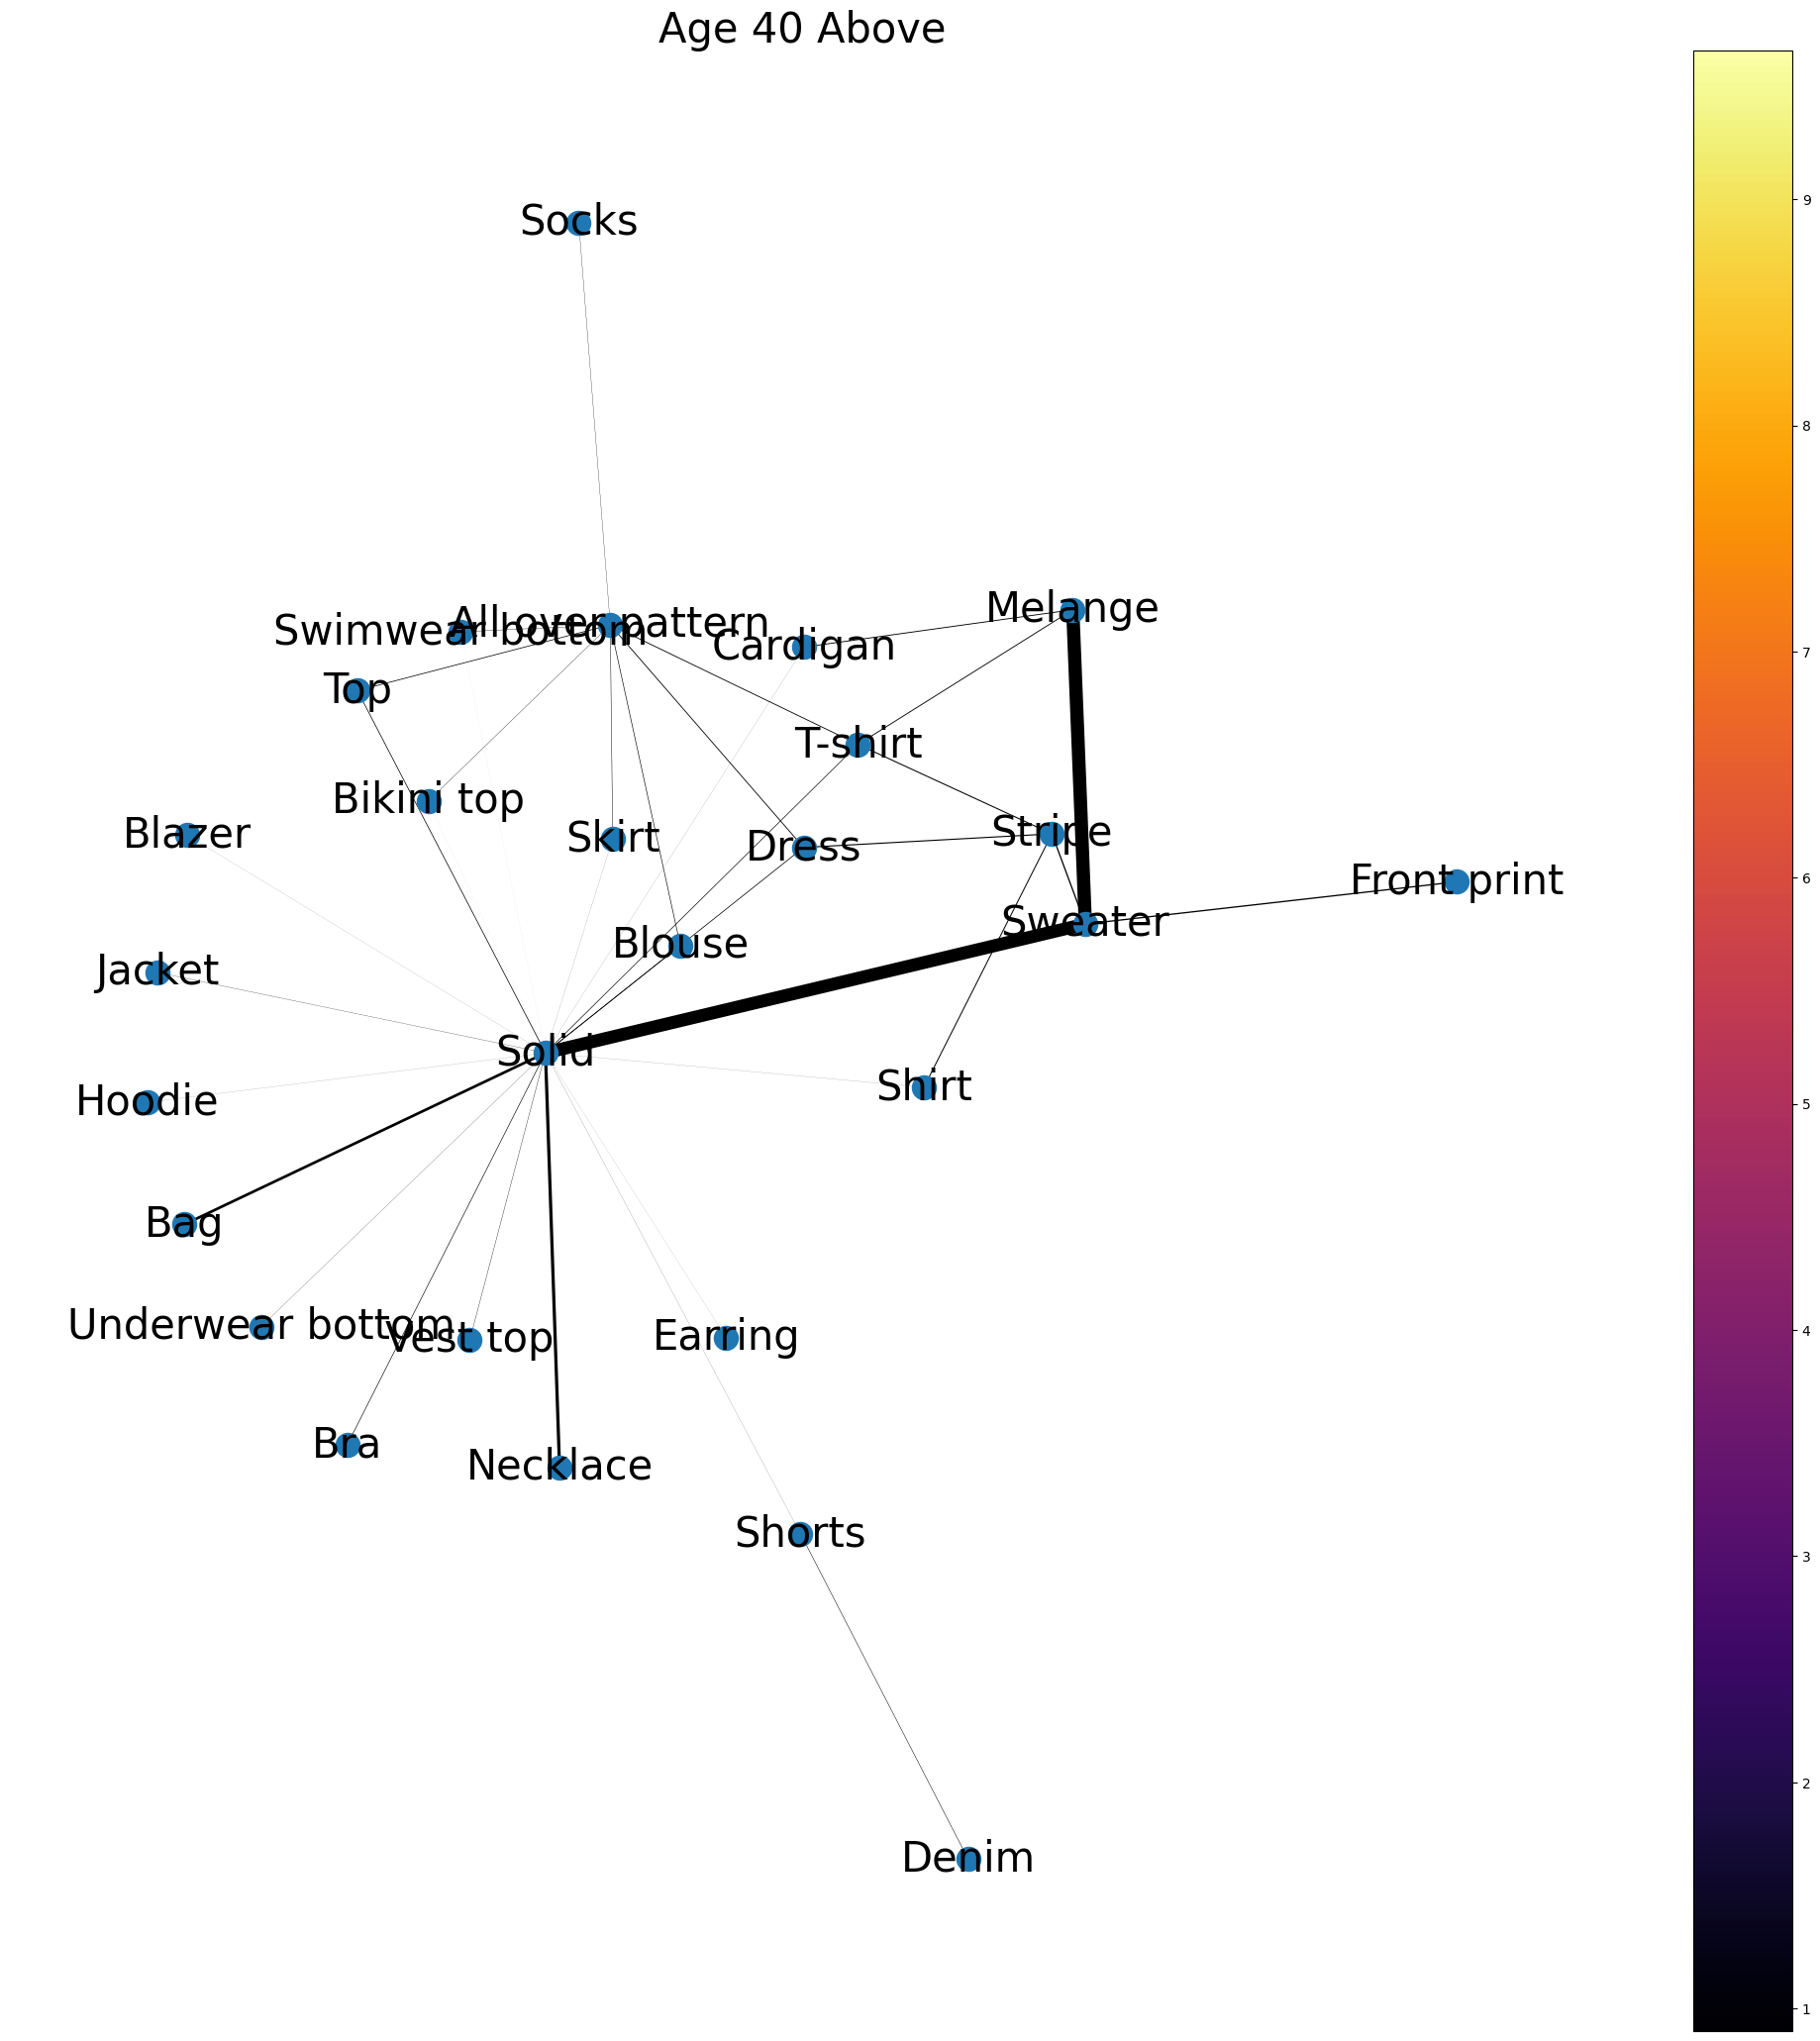

In [138]:
figure(figsize=(20,20))
cmap = plt.cm.inferno
select_edges=((u, v, e) for u,v,e in G.edges(data=True) if e['support'] >=0.9)
H = nx.Graph(select_edges)
f=nx.draw(H,with_labels=True,width=support,font_size=30)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vmin = .9, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.title('Age 40 Above',fontsize=30)
plt.show()

In [136]:
apo_rules(freq40above).sort_values('confidence', ascending = False)

antecedents  \
4292  (Bikini top_Dark Green, Swimwear bottom_Light ...   
3440  (Bikini top_Light Blue, Swimwear bottom_Light ...   
3499  (Bikini top_Dark Green, Swimwear bottom_Light ...   
3538  (Bikini top_Light Blue, Swimwear bottom_Light ...   
2972  (Swimwear bottom_Light Blue, Swimwear bottom_L...   
...                                                 ...   
4809                                     (Sweater_Grey)   
4916                                     (Sweater_Grey)   
4643                                     (Sweater_Grey)   
4632                                     (Sweater_Grey)   
4931                                     (Sweater_Grey)   

                                   consequents  antecedent support  \
4292                 (Bikini top_Light Orange)            0.000106   
3440                 (Bikini top_Light Yellow)            0.000125   
3499                 (Bikini top_Light Orange)            0.000120   
3538                 (Bikini top_Light Yellow)            0.000120   
2972                 (Bikini top_Light Yellow)            0.000135   
...                                        ...                 ...   
4809                          (Shirt_Dark Red)            0.035431   
4916       (Sweater_Dark Green, Sweater_Beige)            0.035431   
4643  (Sweater_Light Grey, Sweater_Dark Green)            0.035431   
4632                         (Pyjama set_Grey)            0.035431   
4931         (Sweater_Beige, Sweater_Dark Red)            0.035431   

      consequent support   support  confidence        lift  leverage  \
4292            0.002454  0.000106    1.000000  407.531373  0.000106   
3440            0.001747  0.000125    1.000000  572.564738  0.000125   
3499            0.002454  0.000120    1.000000  407.531373  0.000120   
3538            0.001747  0.000120    1.000000  572.564738  0.000120   
2972            0.001747  0.000130    0.964286  552.115998  0.000130   
...                  ...       ...         ...         ...       ...   
4809            0.002136  0.000101    0.002852    1.334915  0.000025   
4916            0.000625  0.000101    0.002852    4.559250  0.000079   
4643            0.000481  0.000101    0.002852    5.927025  0.000084   
4632            0.002401  0.000101    0.002852    1.187781  0.000016   
4931            0.000587  0.000101    0.002852    4.858217  0.000080   

      conviction  
4292         inf  
3440         inf  
3499         inf  
3538         inf  
2972   27.951097  
...          ...  
4809    1.000718  
4916    1.002233  
4643    1.002377  
4632    1.000452  
4931    1.002271  

[4970 rows x 9 columns]

# Visualiazing bipartite graphs

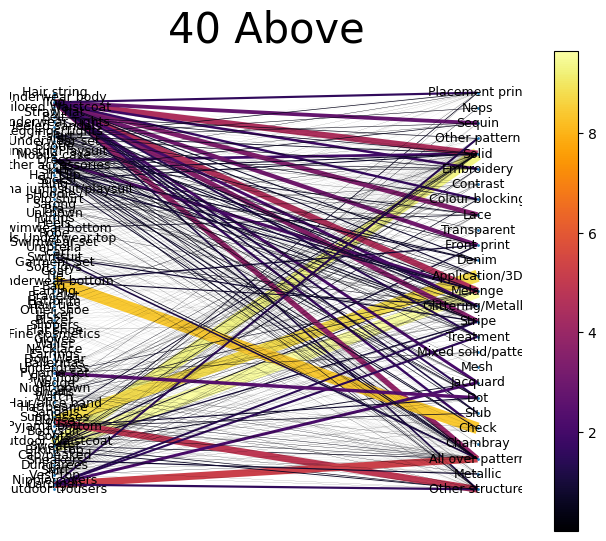

In [257]:
G = nx.Graph( node_size=0.5,node_label_offset=0.1)
G.add_nodes_from(freq2items40above.prod_name,size=10, bipartite=0)
G.add_nodes_from(freq2items40above.pattern, bipartite=1)
#G.add_edges_from(freq2items40above.support)
#G.add_edges_from(support)
G.add_edges_from(edges)
pos = nx.bipartite_layout(G, freq2items40above.prod_name,scale=2,aspect_ratio=1000)
nx.draw(G, width=support,node_size=1,edge_color=support,pos=pos,edge_cmap=cmap,with_labels=True, font_size=9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.title('40 Above',fontsize=30)
plt.show()

In [328]:
freqsel=freq2items40above[freq2items40above.support>=0.9]

I am not able to increase the spacing on pattern side 

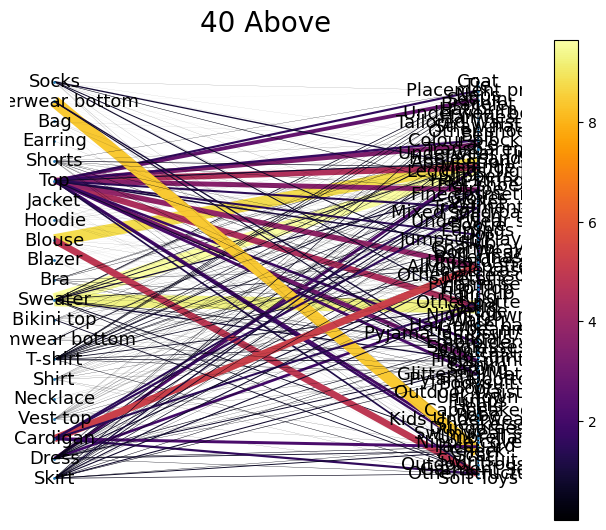

In [366]:
G = nx.Graph( node_size=1,node_label_offset=10)
G.add_nodes_from(freqsel.prod_name,size=10, bipartite=0)
G.add_nodes_from(freqsel.pattern, bipartite=1)
#G.add_edges_from(freq2items40above.support)
#G.add_edges_from(support)
G.add_edges_from(edges)
pos = nx.bipartite_layout(G, freqsel.prod_name,scale=0.01,aspect_ratio=10)
nx.draw(G, width=support,node_size=1,edge_color=support,pos=pos,edge_cmap=cmap,with_labels=True, font_size=13)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)

plt.title('40 Above',fontsize=20)
plt.show()